In [1]:
!pip install category_encoders --quiet

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
project_path = '/content/drive/My Drive/data-mining/model/'
if project_path not in sys.path:
    sys.path.append(project_path)
print(sys.path)

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/My Drive/data-mining/model/']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from my_pytorch_utils.pytorch_model import PyTorchRegressorWrapper
import xgboost as xgb
import time  # To time the tuning process
from sklearn.inspection import permutation_importance
import warnings

In [5]:
df_train = pd.read_csv('/content/drive/My Drive/data-mining/train_data/train_data_preprocessed_no_outliers.csv')
df_test = pd.read_csv('/content/drive/My Drive/data-mining/train_data/test_data_preprocessed.csv')

In [6]:
len(df_train)

325236

In [7]:
df_train.head()

,id,url,region,region_url,year,condition,fuel,odometer,VIN,image_url,...,model,manufacturer,type,drive,cylinders,title_status,paint_color,year_range,transmission,size
0,7310804917,https://austin.craigslist.org/ctd/d/houston-20...,austin,https://austin.craigslist.org,2017.0,missing,gas,48544.0,1FTEW1EFXHKC11214,https://images.craigslist.org/00202_fA8s718RZU...,...,f-150,ford,truck,4wd,8,clean,black,2010-2020,automatic,full-size
1,7315327041,https://sandiego.craigslist.org/nsd/ctd/d/palm...,san diego,https://sandiego.craigslist.org,2018.0,missing,gas,53103.0,5J8YD3H53JL004103,https://images.craigslist.org/00Q0Q_b7u8uPQBQE...,...,mdx,acura,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
2,7310280162,https://albany.craigslist.org/ctd/d/new-lebano...,albany,https://albany.craigslist.org,2016.0,excellent,gas,73394.0,1FT7W2B6XGEA62285,https://images.craigslist.org/00c0c_jcqfcYXhpQ...,...,f-250 super duty,ford,truck,4wd,8,clean,white,2010-2020,automatic,full-size
3,7306277173,https://york.craigslist.org/ctd/d/york-2018-bu...,york,https://york.craigslist.org,2018.0,good,gas,38459.0,5GAERBKW1JJ210810,https://images.craigslist.org/00w0w_36PXCHco1K...,...,enclave essence sport,buick,SUV,fwd,6,clean,white,2010-2020,automatic,full-size
4,7303579544,https://tippecanoe.craigslist.org/cto/d/danvil...,lafayette / west lafayette,https://tippecanoe.craigslist.org,2008.0,excellent,gas,173267.0,NaN,https://images.craigslist.org/00I0I_56zzYCrxDH...,...,f150 fx/2 sport,ford,pickup,rwd,8,clean,black,2000-2010,automatic,full-size


In [8]:
df_test.head()

,id,url,region,region_url,year,condition,fuel,odometer,VIN,image_url,...,model,manufacturer,type,drive,cylinders,title_status,paint_color,year_range,transmission,size
0,7315883828,https://lakeland.craigslist.org/ctd/d/lakeland...,lakeland,https://lakeland.craigslist.org,2017.0,good,gas,38094.0,1FTFX1EG9HKD14814,https://images.craigslist.org/00s0s_lRS7etJoVE...,...,f150 super cab lariat,ford,pickup,4wd,6,clean,white,2010-2020,automatic,full-size
1,7308399808,https://littlerock.craigslist.org/ctd/d/clinto...,little rock,https://littlerock.craigslist.org,2015.0,missing,gas,30200.0,NaN,https://images.craigslist.org/00A0A_kJsL7mVMCg...,...,corvette,chevrolet,convertible,rwd,8,clean,white,2010-2020,automatic,full-size
2,7312663807,https://wheeling.craigslist.org/ctd/d/follansb...,northern panhandle,https://wheeling.craigslist.org,2013.0,missing,gas,92965.0,NaN,https://images.craigslist.org/00K0K_2oCjTKrjd9...,...,328i,bmw,sedan,fwd,6,clean,white,2010-2020,automatic,full-size
3,7315368523,https://eugene.craigslist.org/ctd/d/cottage-gr...,eugene,https://eugene.craigslist.org,2019.0,missing,other,47105.0,1GNSKGKC7KR124145,https://images.craigslist.org/00H0H_3hFsa4lTxO...,...,suburban ls,chevrolet,SUV,4wd,8,clean,black,2010-2020,automatic,full-size
4,7309863303,https://waterloo.craigslist.org/ctd/d/waterloo...,waterloo / cedar falls,https://waterloo.craigslist.org,2002.0,excellent,gas,229031.0,2C4GP44392R547816,https://images.craigslist.org/00z0z_2dqRgOP60s...,...,town country,chrysler,mini-van,fwd,6,clean,blue,2000-2010,automatic,full-size


In [9]:
coloums_to_drop = ['url', 'county', 'lat', 'long', 'region_url', 'posting_date', 'VIN', 'image_url', 'description', 'id', 'year_range']
df_train.drop(columns=coloums_to_drop, inplace=True)

In [10]:
df_train.head()

,region,year,condition,fuel,odometer,state,price,model,manufacturer,type,drive,cylinders,title_status,paint_color,transmission,size
0,austin,2017.0,missing,gas,48544.0,tx,46995,f-150,ford,truck,4wd,8,clean,black,automatic,full-size
1,san diego,2018.0,missing,gas,53103.0,ca,0,mdx,acura,SUV,fwd,6,clean,white,automatic,full-size
2,albany,2016.0,excellent,gas,73394.0,ny,36900,f-250 super duty,ford,truck,4wd,8,clean,white,automatic,full-size
3,york,2018.0,good,gas,38459.0,pa,29590,enclave essence sport,buick,SUV,fwd,6,clean,white,automatic,full-size
4,lafayette / west lafayette,2008.0,excellent,gas,173267.0,in,7950,f150 fx/2 sport,ford,pickup,rwd,8,clean,black,automatic,full-size


In [11]:
# Make a copy for EDA to avoid altering the original df_train used for modeling pipeline
df_eda = df_train.copy()

In [12]:
# Define numerical and categorical columns based on your dataset inspection and modeling choices
# Note: 'price' is the target, 'year' and 'odometer' are numerical predictors.
numerical_eda_cols = ['price', 'year', 'odometer']
categorical_eda_cols = ['cylinders', 'manufacturer', 'fuel', 'drive', 'transmission', 'type', 'condition', 'size', 'title_status', 'paint_color']
# 'region', 'state', 'model' are very high cardinality, requires special handling (e.g., top N, aggregation)


--- 1. Numerical Feature Correlation ---


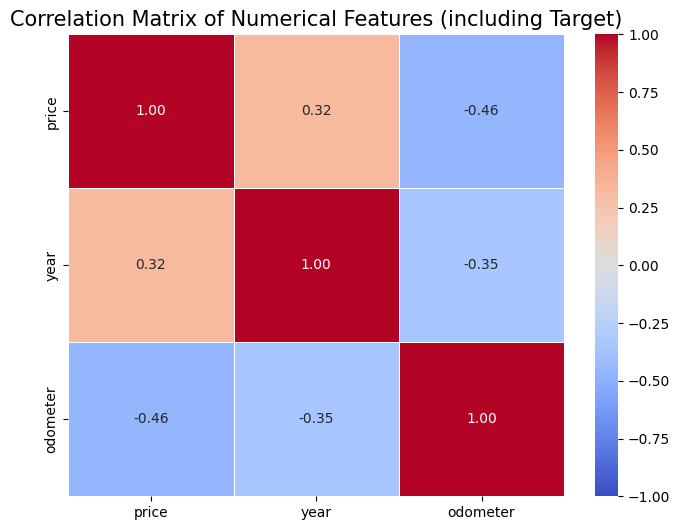


Observations from numerical correlation:
- Price and Year: Positive correlation (newer cars tend to be more expensive).
- Price and Odometer: Negative correlation (cars with more miles tend to be cheaper).
- Year and Odometer: Moderate negative correlation (older cars tend to have more miles).



In [13]:
# 1. Numerical Feature Correlation
print("--- 1. Numerical Feature Correlation ---")
plt.figure(figsize=(8, 6))
numerical_corr = df_eda[numerical_eda_cols].corr()
sns.heatmap(numerical_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features (including Target)", fontsize=15)
plt.show()
print("\nObservations from numerical correlation:")
print("- Price and Year: Positive correlation (newer cars tend to be more expensive).")
print("- Price and Odometer: Negative correlation (cars with more miles tend to be cheaper).")
print("- Year and Odometer: Moderate negative correlation (older cars tend to have more miles).\n")


<ipython-input-14-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


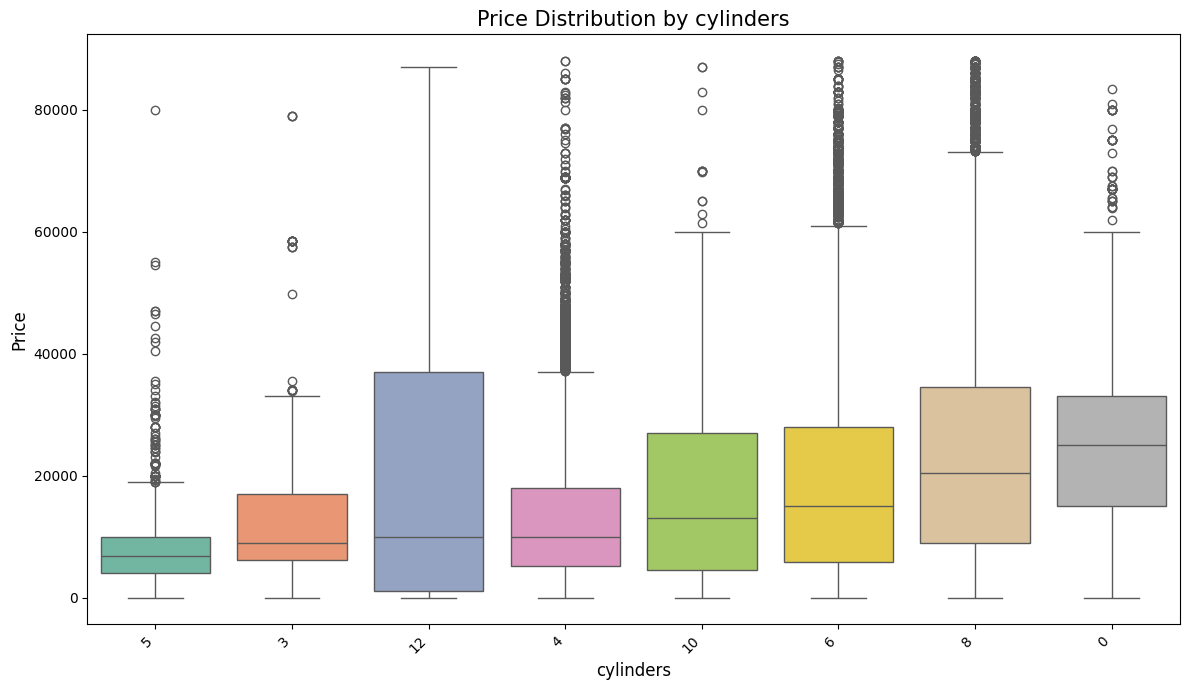

Median price by cylinders:
cylinders
0     24990.0
8     20500.0
6     14999.0
10    12995.0
4      9999.0
12     9995.0
3      8990.0
5      6800.0
Name: price, dtype: float64



<ipython-input-14-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


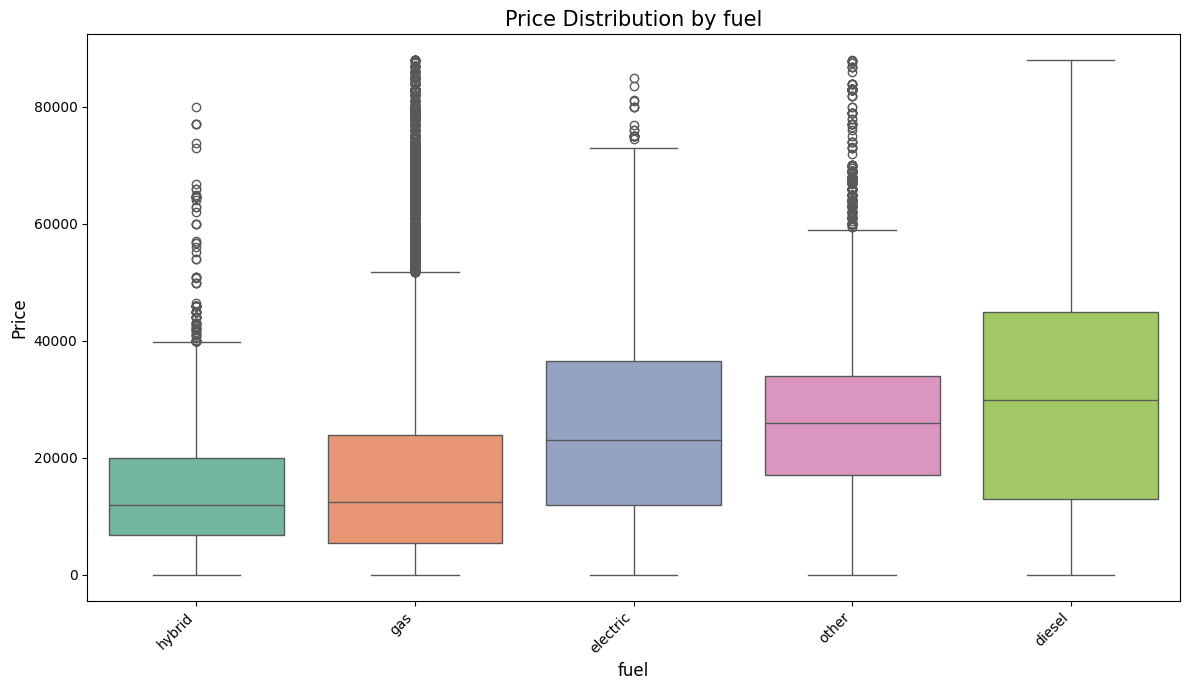

Median price by fuel:
fuel
diesel      29900.0
other       25990.0
electric    22995.0
gas         12490.0
hybrid      11995.0
Name: price, dtype: float64



<ipython-input-14-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


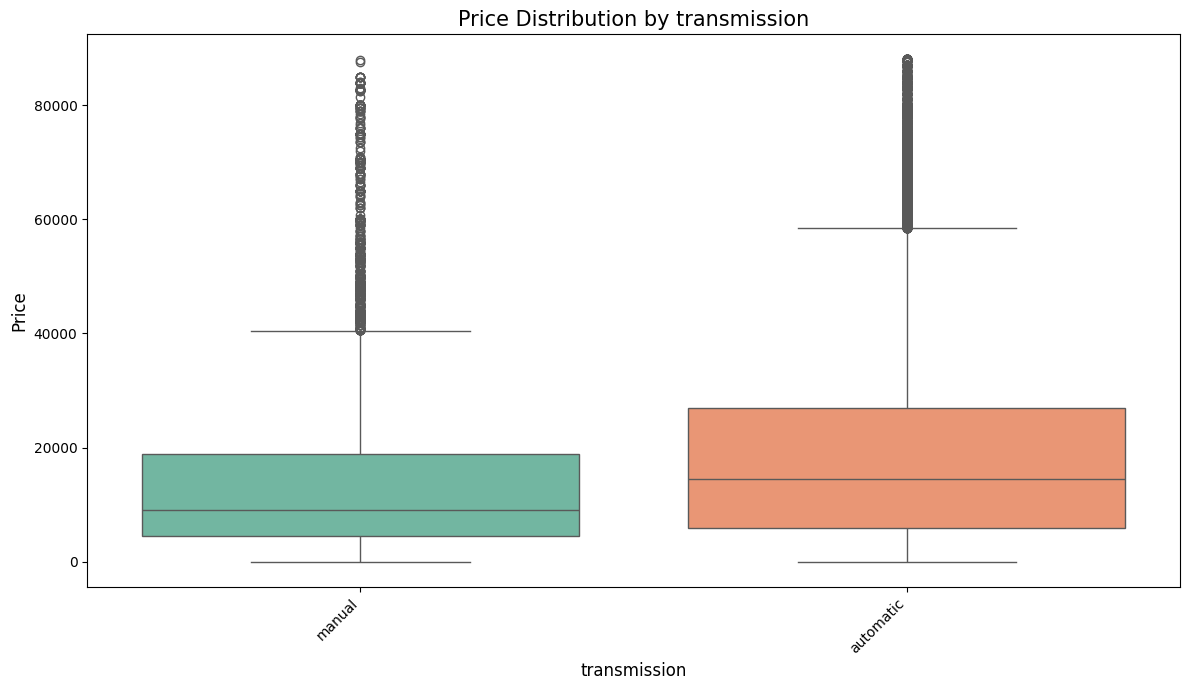

Median price by transmission:
transmission
automatic    14500.0
manual        9000.0
Name: price, dtype: float64



<ipython-input-14-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


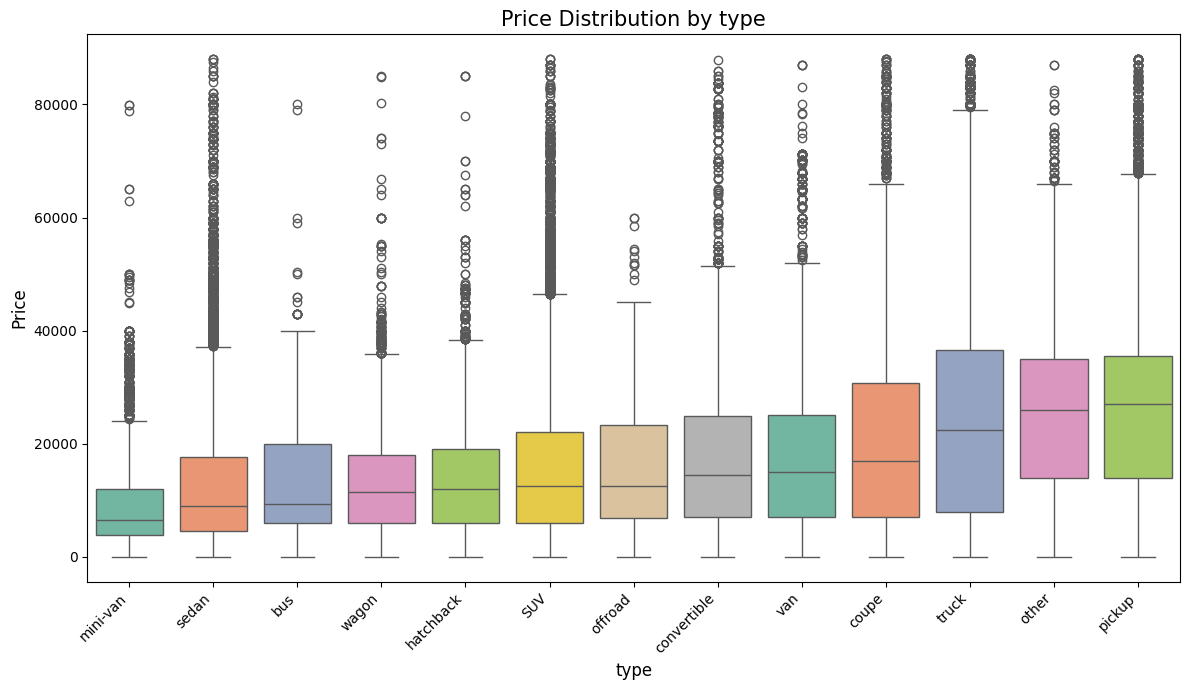

Median price by type:
type
pickup         26988.0
other          25990.0
truck          22500.0
coupe          17000.0
van            14997.0
convertible    14388.0
offroad        12500.0
SUV            12500.0
hatchback      11998.0
wagon          11452.0
bus             9250.0
sedan           8995.0
mini-van        6500.0
Name: price, dtype: float64



<ipython-input-14-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


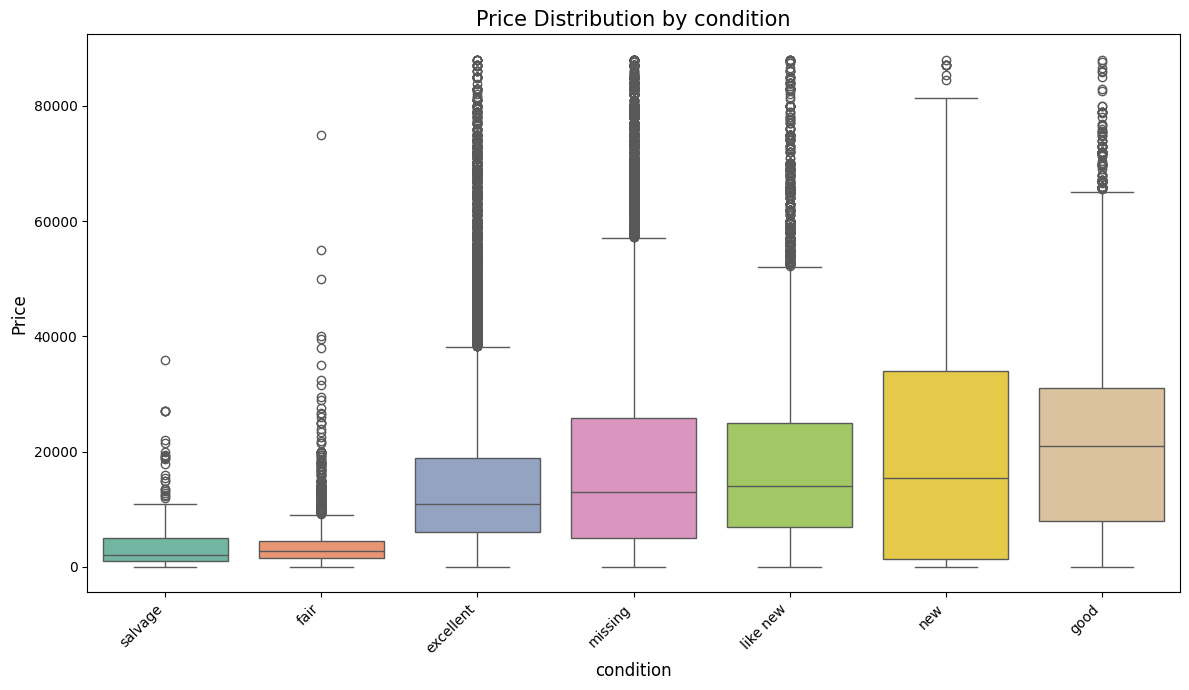

Median price by condition:
condition
good         20986.0
new          15400.0
like new     13995.0
missing      12999.0
excellent    10995.0
fair          2750.0
salvage       1999.0
Name: price, dtype: float64



<ipython-input-14-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


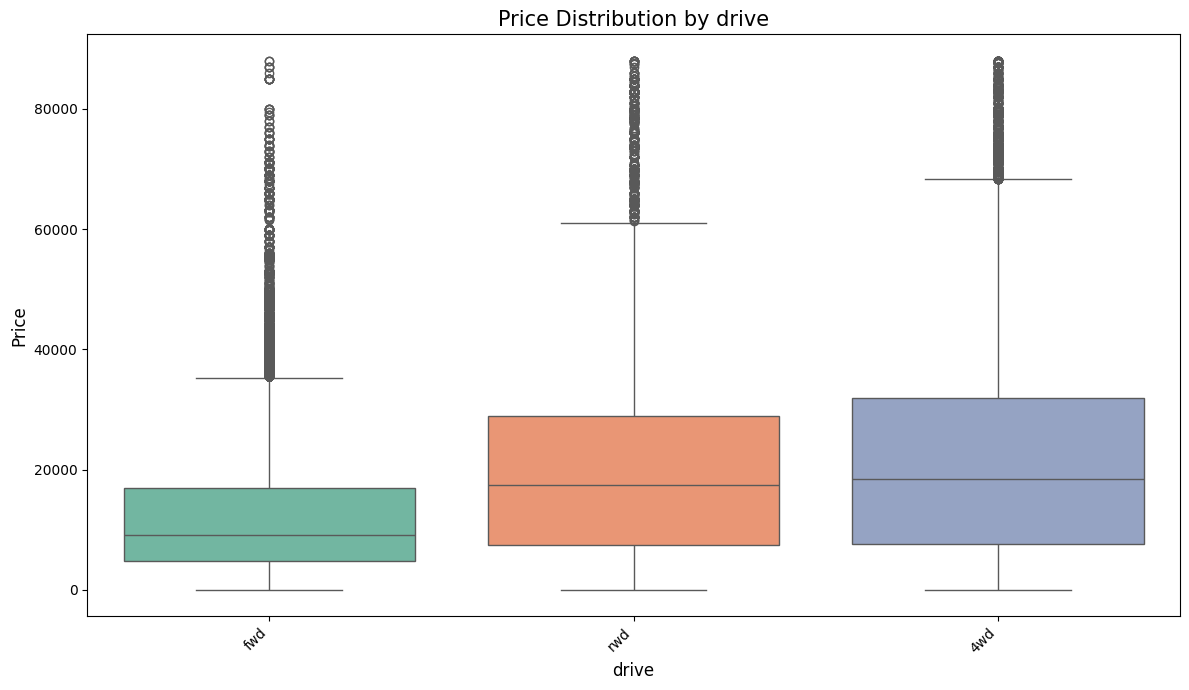

Median price by drive:
drive
4wd    18500.0
rwd    17500.0
fwd     9100.0
Name: price, dtype: float64



<ipython-input-14-3fdcfeed5ed5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")


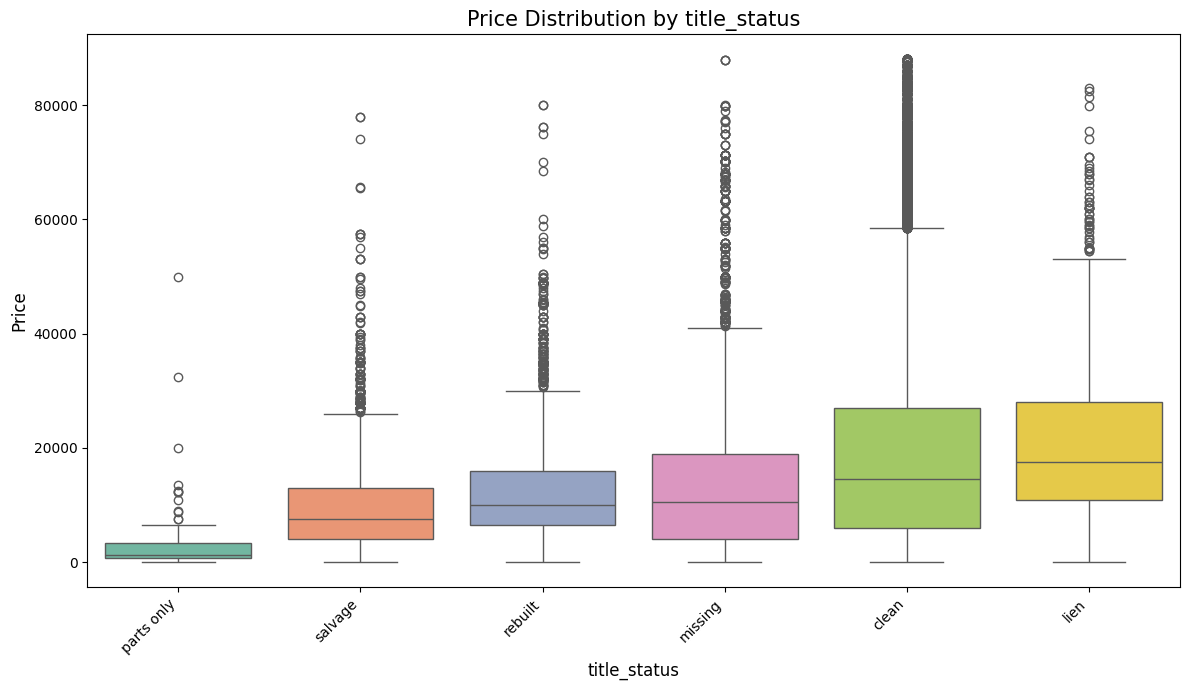

Median price by title_status:
title_status
lien          17500.0
clean         14499.0
missing       10495.0
rebuilt       10000.0
salvage        7500.0
parts only     1325.0
Name: price, dtype: float64


--- Example: Price by Top N Manufacturers ---


<ipython-input-14-3fdcfeed5ed5>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='manufacturer', y='price', data=df_top_manu, order=manu_order, palette="viridis")


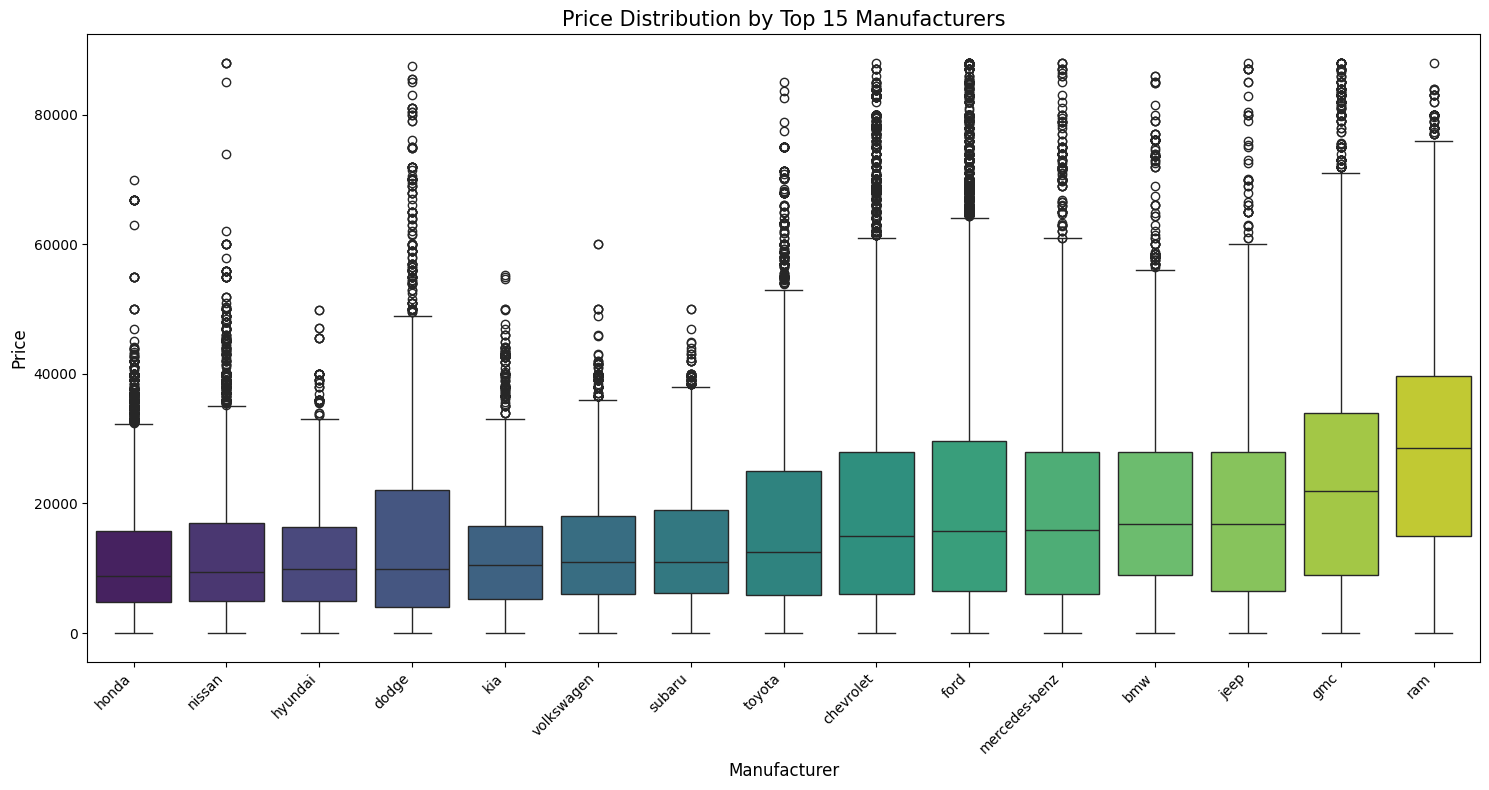

Median price by Top 15 Manufacturers (sorted by median price):
manufacturer
ram              28590.0
gmc              21990.0
jeep             16900.0
bmw              16825.0
mercedes-benz    15900.0
ford             15695.0
chevrolet        14900.0
toyota           12500.0
subaru           10995.0
volkswagen       10995.0
kia              10572.0
dodge             9900.0
hyundai           9877.0
nissan            9442.0
honda             8795.0
Name: price, dtype: float64



In [14]:
# 2. Categorical Features vs. Target (Price)
# Select a subset of categorical features for detailed plotting to avoid clutter
# Features with low to moderate cardinality are good candidates
cat_cols_for_price_boxplot = ['cylinders', 'fuel', 'transmission', 'type', 'condition', 'drive', 'title_status']

for col in cat_cols_for_price_boxplot:

    # To make boxplots more readable, order categories by median price
    order = df_eda.groupby(col)['price'].median().sort_values().index

    plt.figure(figsize=(12, 7))
    sns.boxplot(x=col, y='price', data=df_eda, order=order, palette="Set2")
    plt.title(f'Price Distribution by {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Display median prices for reference
    print(f"Median price by {col}:\n{df_eda.groupby(col)['price'].median().sort_values(ascending=False)}\n")

# Example for a high-cardinality feature: Manufacturer (Top N by count)
print("\n--- Example: Price by Top N Manufacturers ---")
top_n = 15
top_manufacturers = df_eda['manufacturer'].value_counts().nlargest(top_n).index
df_top_manu = df_eda[df_eda['manufacturer'].isin(top_manufacturers)]

# Order by median price
manu_order = df_top_manu.groupby('manufacturer')['price'].median().sort_values().index

plt.figure(figsize=(15, 8))
sns.boxplot(x='manufacturer', y='price', data=df_top_manu, order=manu_order, palette="viridis")
plt.title(f'Price Distribution by Top {top_n} Manufacturers', fontsize=15)
plt.xlabel('Manufacturer', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(f"Median price by Top {top_n} Manufacturers (sorted by median price):\n{df_top_manu.groupby('manufacturer')['price'].median().sort_values(ascending=False)}\n")


<ipython-input-15-54d9d22cf423>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")


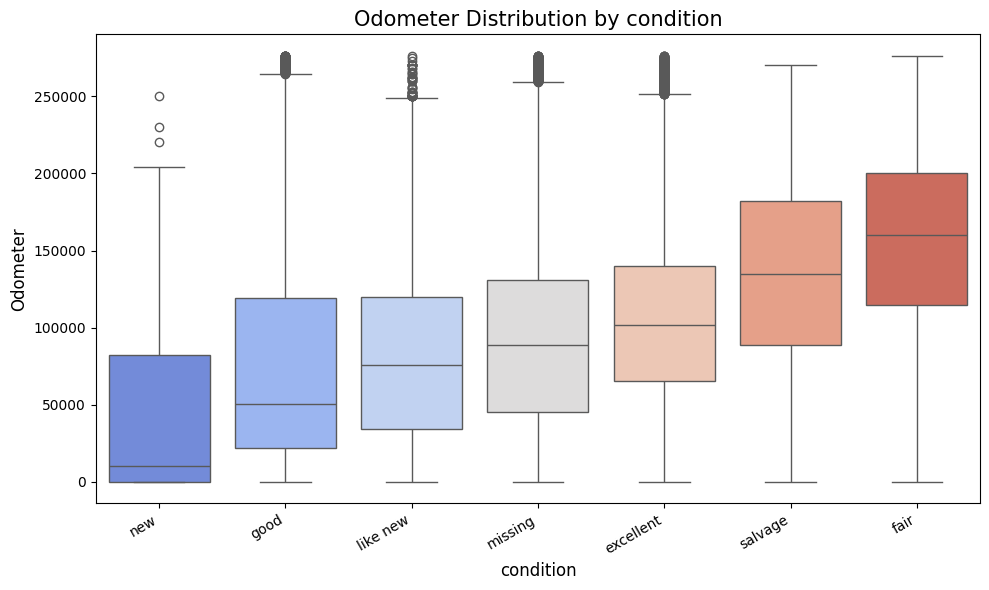

Median odometer by condition:
condition
fair         160225.0
salvage      134584.0
excellent    102000.0
missing       88455.5
like new      76000.0
good          50252.0
new           10000.0
Name: odometer, dtype: float64



<ipython-input-15-54d9d22cf423>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")


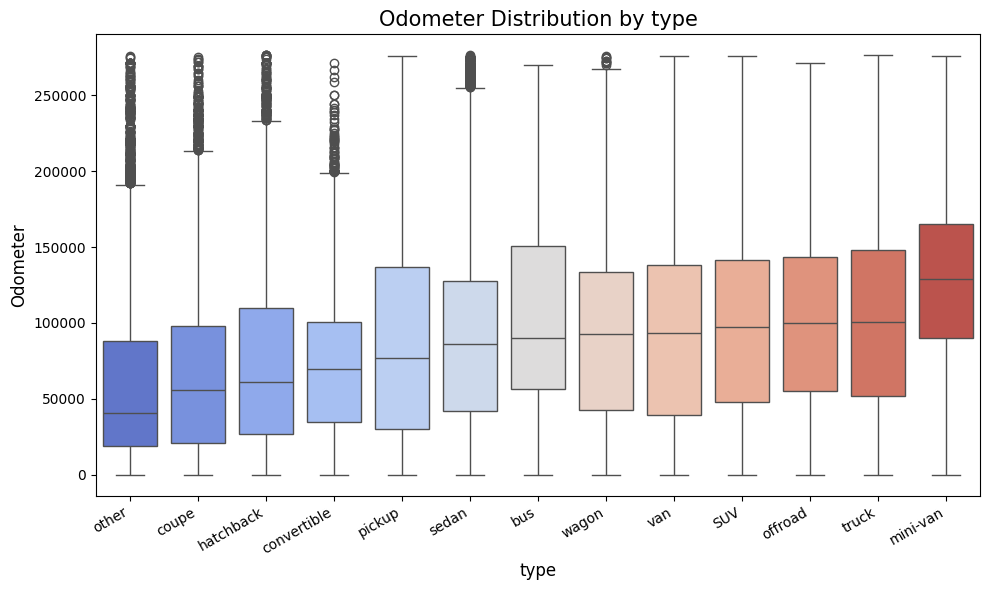

Median odometer by type:
type
mini-van       128878.0
truck          100706.0
offroad        100000.0
SUV             97617.0
van             93450.0
wagon           93000.0
bus             90000.0
sedan           86000.0
pickup          77022.0
convertible     69451.0
hatchback       60984.0
coupe           56075.0
other           40405.0
Name: odometer, dtype: float64



<ipython-input-15-54d9d22cf423>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")


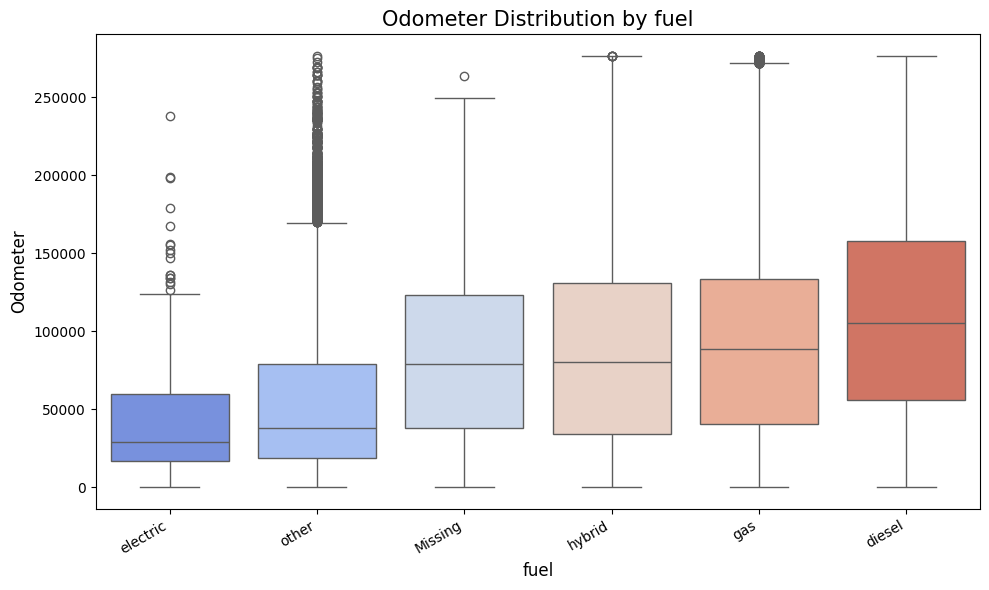

Median odometer by fuel:
fuel
diesel      105000.0
gas          88692.0
hybrid       80000.0
Missing      78699.0
other        37647.0
electric     28805.0
Name: odometer, dtype: float64



In [15]:
# 3. Categorical Features vs. Another Numerical Feature (e.g., Odometer)
cat_cols_for_odo_boxplot = ['condition', 'type', 'fuel'] # Example features

for col in cat_cols_for_odo_boxplot:
    df_eda[col] = df_eda[col].fillna('Missing') # Ensure NaNs are handled for plotting
    order = df_eda.groupby(col)['odometer'].median().sort_values().index # Order by median odometer

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='odometer', data=df_eda, order=order, palette="coolwarm")
    # Filter out extreme odometer outliers for better visualization if necessary
    # sns.boxplot(x=col, y='odometer', data=df_eda[df_eda['odometer'] < df_eda['odometer'].quantile(0.99)], order=order)
    plt.title(f'Odometer Distribution by {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Odometer', fontsize=12)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()
    print(f"Median odometer by {col}:\n{df_eda.groupby(col)['odometer'].median().sort_values(ascending=False)}\n")



In [16]:
print(f"Original train shape: {df_train.shape}")
df_train = df_train[df_train['price'] > 0].copy() 
print(f"Train shape after removing price <= 0: {df_train.shape}")

Original train shape: (325236, 16)
Train shape after removing price <= 0: (301498, 16)


In [17]:
print(f"Original test shape: {df_test.shape}")
df_test = df_test[df_test['price'] > 0].copy()
print(f"Test shape after removing price <= 0: {df_test.shape}")

Original test shape: (81184, 27)
Test shape after removing price <= 0: (75359, 27)


In [18]:
# 2. Define X and y
X_train_df = df_train.drop(columns=['price'])
y_train_original = df_train['price'] # Keep original for final evaluation comparison if needed

X_test_df = df_test.drop(columns=['price'])
y_test_original = df_test['price']   # This will be our final reference for y_test


In [19]:
# 3. Apply log transformation to y_train for model fitting
y_train_log = np.log(y_train_original)
# We will use y_test_original for final evaluation after inverse transforming predictions.
# y_test_log is not directly used by the model fitting/tuning loop for y.
print(f"\nTarget variable 'price' log-transformed for training.")
print(f"y_train_original mean: {y_train_original.mean():.2f}, std: {y_train_original.std():.2f}")
print(f"y_train_log mean: {y_train_log.mean():.2f}, std: {y_train_log.std():.2f}")



Target variable 'price' log-transformed for training.
y_train_original mean: 18758.62, std: 14203.02
y_train_log mean: 9.42, std: 1.22


In [20]:
X_train = X_train_df
y_train = y_train_log
X_test = X_test_df

In [21]:
!pip install pygam

In [22]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [23]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from pygam import LinearGAM

# Define columns
cat_columns = ['cylinders', 'manufacturer', 'state', 'model', 'fuel', 'drive', 'transmission', 'type', 'condition', 'size', 'title_status', 'paint_color' ]
num_columns = ['year', 'odometer', 'cylinders']

# Create preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer([
    # For categorical features, split by encoding typ
    ('region_enc', Pipeline([
        ('encoder', ce.BinaryEncoder())
    ]), ['region']),

    ('freq_enc', Pipeline([
        ('encoder', ce.CountEncoder())
    ]), ['manufacturer', 'state', 'model']),

    ('onehot_enc', Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), ['fuel', 'drive', 'transmission', 'type', 'title_status', 'paint_color']),

    ('ordinal_enc', Pipeline([
        ('encoder', OrdinalEncoder())
    ]), ['condition', 'size']),

    # For numerical features
    ('num', Pipeline([
        ('scaler', StandardScaler())
    ]), num_columns)
], remainder='drop')


# Dictionary of regressors
model_pipelines = {
    # --- Linear Models ---
   'linear_simple': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression(n_jobs=-1),)
    ]),
    'linear_poly': Pipeline([
        ('preprocessor', preprocessor),
        ('poly_features', PolynomialFeatures(include_bias=False)), # Degree will be tuned
        ('regressor', LinearRegression(n_jobs=-1))
    ]),
    #'knn': Pipeline([
        #('preprocessor', preprocessor),
        #('regressor', KNeighborsRegressor(n_jobs=-1))
    #]),
    #'ridge': Pipeline([ # NEW: Simple Ridge
        #('preprocessor', preprocessor),
        #('regressor', Ridge(random_state=42)) # alpha will be tuned
   # ]),
    #'ridge_poly': Pipeline([ # NEW: Polynomial Ridge
       # ('preprocessor', preprocessor),
       # ('poly_features', PolynomialFeatures(include_bias=False)), # Degree will be tuned
       # ('regressor', Ridge(random_state=42)) # alpha will be tuned
  # ]),
    #'lasso': Pipeline([ # NEW: Simple Lasso
        #('preprocessor', preprocessor),
        #('regressor', Lasso(random_state=42)) # alpha will be tuned
   # ]),
  #  #'lasso_poly': Pipeline([ # NEW: Polynomial Lasso
        #('preprocessor', preprocessor),
        #('poly_features', PolynomialFeatures(include_bias=False)), # Degree will be tuned
       # ('regressor', Lasso(random_state=42)) # alpha will be tuned
 #   ]),
    #'gam': Pipeline([ # NEW: Generalized Additive Models
       # ('preprocessor', preprocessor),
       # ('regressor', LinearGAM())
   # ]),
    #'svr': Pipeline([
      #  ('preprocessor', preprocessor),
      #  ('regressor', SVR()) # Note: SVR is computationally expensive, esp. with many features (like from poly)
  #  ]),
    'dt': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'rf': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
    ]),
   # 'gb': Pipeline([ # NEW: gradBoost
    #    ('preprocessor', preprocessor),
     #   ('regressor', HistGradientBoostingRegressor(random_state=42))
   # ]),
    'xgb': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')),
    ]),
    #'pytorch_linear': Pipeline([
       # ('preprocessor', preprocessor), # Use the SAME preprocessor!
       # ('regressor', PyTorchRegressorWrapper(lr=0.01, epochs=50, batch_size=64)) # Adjust hyperparameters
   # ])
}

In [24]:
import numpy as np
from scipy.stats import loguniform, uniform, randint
from sklearn.model_selection import RandomizedSearchCV
# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    # --- Linear Models ---
    'linear_simple': {
        'regressor__fit_intercept': [True],
    },
    'linear_poly': {
        'poly_features__degree': [2], # Just test degree 2 initially
        'regressor__fit_intercept': [True],
    },
    'ridge': {
        'regressor__alpha': loguniform(1e-2, 1e1), # Narrower range for alpha
        'regressor__fit_intercept': [True],
        # 'regressor__solver': ['auto', 'svd', ...], # Removed solver tuning for simplicity
    },
    'ridge_poly': {
        'poly_features__degree': [2],
        'regressor__alpha': loguniform(1e-2, 1e1),
        'regressor__fit_intercept': [True],
    },
    'lasso': {
        'regressor__alpha': loguniform(1e-3, 1e0), # Narrower range
        'regressor__max_iter': [1000, 2000],      # Fewer choices for max_iter
        'regressor__fit_intercept': [True]
    },
    'lasso_poly': {
        'poly_features__degree': [2],
        'regressor__alpha': loguniform(1e-3, 1e0),
        'regressor__max_iter': [1000, 2000],
        'regressor__fit_intercept': [True]
    },
    'knn': {
        'regressor__n_neighbors': randint(3, 20), # Number of neighbors (e.g., 3 to 19)
        'regressor__weights': ['uniform', 'distance'], # How to weight neighbors
        'regressor__p': [1, 2] # Power parameter for Minkowski distance: 1 for Manhattan, 2 for Euclidean
        # 'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] # Usually 'auto' is fine
        # 'regressor__leaf_size': randint(20, 41) # For BallTree or KDTree, less critical usually
    },
    'gam': {
        'regressor__n_splines': randint(8, 16),   # Fewer splines
        'regressor__lam': loguniform(1e-2, 1e1), # Narrower lambda
    },
    'svr': {
        'regressor__C': loguniform(1e0, 1e2),      # Narrower C
        'regressor__epsilon': [0.1, 0.01],         # Fewer epsilon choices
        'regressor__gamma': loguniform(1e-3, 1e-2),# Narrower gamma
        'regressor__kernel': ['rbf']              # Focus on rbf kernel initially
    },
    'dt': {
        'regressor__max_depth': [5, 10, 15, None], # Fewer depth options
        'regressor__min_samples_split': randint(5, 16), # Narrower range
        'regressor__min_samples_leaf': randint(5, 16),  # Narrower range
        'regressor__max_features': ['sqrt', 0.7],     # Fewer options
        # 'regressor__ccp_alpha': loguniform(1e-4, 1e-1) # Can remove ccp_alpha for quicker DT
    },
    'rf': { # Parameters already adjusted for lower memory in previous discussion
        'regressor__n_estimators': randint(50, 101),      # Fewer estimators
        'regressor__max_depth': list(range(5, 13, 3)),   # Shallower: [5, 8, 11]
        'regressor__min_samples_split': randint(10, 31), # Higher min samples
        'regressor__min_samples_leaf': randint(10, 31),  # Higher min samples
        'regressor__max_features': ['sqrt'],             # Just 'sqrt'
        'regressor__bootstrap': [True],
        # 'regressor__ccp_alpha': loguniform(1e-3, 1e-1) # Can remove for quicker RF
    },
    'gb': {
        'regressor__n_estimators': randint(50, 151),     # Fewer estimators
        'regressor__learning_rate': loguniform(0.01, 0.1),# Narrower learning rate
        'regressor__max_depth': [3, 5, 7],              # Fewer depth choices
        'regressor__min_samples_split': randint(5, 16),
        'regressor__min_samples_leaf': randint(5, 16),
        'regressor__max_features': ['sqrt'],
        'regressor__subsample': [0.7, 0.8, 0.9],        # Discrete subsample options
    },
    'xgb': {
        'regressor__n_estimators': randint(50, 151),
        'regressor__learning_rate': loguniform(0.01, 0.1),
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_child_weight': [1, 3, 5],
        'regressor__subsample': [0.7, 0.8],
        'regressor__colsample_bytree': [0.7, 0.8],
        # 'regressor__colsample_bylevel': uniform(0.5, 0.5), # Removed for simplicity
        # 'regressor__gamma': loguniform(1e-3, 5.0),       # Removed for simplicity
        # 'regressor__reg_alpha': loguniform(1e-3, 5.0),   # Removed for simplicity
        # 'regressor__reg_lambda': loguniform(1e-3, 10.0)  # Removed for simplicity
    },
    'pytorch_linear': {
        'regressor__lr': loguniform(1e-3, 1e-2), # Narrower LR
        'regressor__epochs': randint(20, 51),   # Fewer epochs
        'regressor__batch_size': [64, 128]      # Fewer batch sizes
    }
}

In [25]:
from tqdm.auto import tqdm
from sklearn.base import clone

def tune_model(X_train_data, y_train_data, model_name_str, pipeline_to_tune, param_dist_dict, cv=5, n_iter=100, error_score_val=np.nan):
    print(f"--- Tuning {model_name_str} (target is log-transformed) ---")
    start_time_tune = time.time()

    random_search = RandomizedSearchCV(
        estimator=pipeline_to_tune,
        param_distributions=param_dist_dict,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_mean_squared_error', # This will be on log(price)
        n_jobs=-1,
        verbose=1,
        random_state=42,
        return_train_score=True, # Important to get train scores from CV folds, though we'll calculate final train score separately
        error_score=error_score_val
    )
    try:
        with parallel_backend('threading'): # Consider if 'loky' or 'multiprocessing' is better for CPU-bound tasks
          random_search.fit(X_train_data, y_train_data)
    except Exception as e:
        print(f"An error occurred during RandomizedSearchCV for {model_name_str}: {e}")
        print(f"Skipping further processing for {model_name_str}.")
        return None # Return None if tuning fails

    end_time_tune = time.time()
    elapsed_time_tune = end_time_tune - start_time_tune
    print(f"\nFinished tuning {model_name_str} in {elapsed_time_tune:.2f} seconds.")

    results = {
        'estimator': None,
        'best_cv_log_mse': np.nan,
        'best_cv_log_rmse': np.nan,
        'train_log_mse': np.nan,
        'train_log_rmse': np.nan,
        'train_log_r2': np.nan
    }

    if hasattr(random_search, 'best_estimator_') and random_search.best_estimator_:
        best_estimator = random_search.best_estimator_
        results['estimator'] = best_estimator

        print(f"Best parameters found for {model_name_str}:")
        best_params_cleaned = {k.split('__', 1)[1] if '__' in k else k: v for k, v in random_search.best_params_.items()}
        print(best_params_cleaned)

        best_cv_log_mse = -random_search.best_score_ # MSE of log(price)
        best_cv_log_rmse = np.sqrt(best_cv_log_mse)  # RMSE of log(price)
        results['best_cv_log_mse'] = best_cv_log_mse
        results['best_cv_log_rmse'] = best_cv_log_rmse
        print(f"Best CV score (MSE of log-price): {best_cv_log_mse:,.4f}")
        print(f"Best CV score (RMSE of log-price): {best_cv_log_rmse:,.4f}")

        # Calculate performance of the best_estimator on the WHOLE training set (log scale)
        print(f"Calculating training scores for {model_name_str} on the full training set (log-scale)...")
        try:
            y_train_pred_log = best_estimator.predict(X_train_data)
            train_log_mse = mean_squared_error(y_train_data, y_train_pred_log)
            train_log_rmse = np.sqrt(train_log_mse)
            train_log_r2 = r2_score(y_train_data, y_train_pred_log)
            results['train_log_mse'] = train_log_mse
            results['train_log_rmse'] = train_log_rmse
            results['train_log_r2'] = train_log_r2
            print(f"  Training MSE (log-price): {train_log_mse:,.4f}")
            print(f"  Training RMSE (log-price): {train_log_rmse:,.4f}")
            print(f"  Training R² (log-price): {train_log_r2:.4f}")
        except Exception as e:
            print(f"  Error calculating training scores for {model_name_str}: {e}")
    else:
        print(f"RandomizedSearchCV for {model_name_str} did not find a successful best estimator.")
        # results will contain NaNs as initialized
    print("-------------------------")
    return results # Return the dictionary


In [26]:
from sklearn.base import clone
from joblib import parallel_backend
from tqdm.auto import tqdm # Import tqdm
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score 
n_iterations = 50
cv_folds = 5

best_models_data_log_target = {}

print(f"Starting hyperparameter tuning with n_iter={n_iterations} and cv={cv_folds} folds (target is log-transformed).\n")

for model_name, pipeline_obj in tqdm(model_pipelines.items(), desc="Overall Model Tuning (Log Target)", unit="model"):
    current_pipeline_instance = clone(pipeline_obj)

    if model_name in param_distributions:
        # tune_model now returns a dictionary
        best_models_data_log_target[model_name] = tune_model(
            X_train, y_train, model_name, current_pipeline_instance,
            param_distributions[model_name], cv=cv_folds, n_iter=n_iterations
        )
    else:
        print(f"--- Training {model_name} (no tuning, target is log-transformed) ---")
        start_time_fit = time.time()
        model_fit_data = { # Initialize structure similar to tune_model output
            'estimator': None,
            'best_cv_log_mse': np.nan, # No CV for non-tuned models
            'best_cv_log_rmse': np.nan,
            'train_log_mse': np.nan,
            'train_log_rmse': np.nan,
            'train_log_r2': np.nan
        }
        try:
            current_pipeline_instance.fit(X_train, y_train) # y_train is y_train_log
            model_fit_data['estimator'] = current_pipeline_instance

            # Calculate training scores for non-tuned model
            y_train_pred_log = current_pipeline_instance.predict(X_train)
            train_log_mse = mean_squared_error(y_train, y_train_pred_log)
            train_log_rmse = np.sqrt(train_log_mse)
            train_log_r2 = r2_score(y_train, y_train_pred_log)

            model_fit_data['train_log_mse'] = train_log_mse
            model_fit_data['train_log_rmse'] = train_log_rmse
            model_fit_data['train_log_r2'] = train_log_r2

            print(f"  Training MSE (log-price): {train_log_mse:,.4f}")
            print(f"  Training RMSE (log-price): {train_log_rmse:,.4f}")
            print(f"  Training R² (log-price): {train_log_r2:.4f}")

        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            # estimator remains None, scores remain NaN
        finally: # Ensure it's always assigned
            best_models_data_log_target[model_name] = model_fit_data

        end_time_fit = time.time()
        print(f"Finished training {model_name} in {end_time_fit - start_time_fit:.2f} seconds.")
        print("-------------------------")

print("\n--- All Tuning and Training with Log-Transformed Target Complete ---")
for model_name, model_data in best_models_data_log_target.items():
    if model_data and model_data['estimator']:
        print(f"Data for {model_name} (trained on log-target): Retrieved successfully.")
    else:
        print(f"Training/Tuning failed or no estimator for {model_name} (trained on log-target).")



Starting hyperparameter tuning with n_iter=50 and cv=5 folds (target is log-transformed).



Overall Model Tuning (Log Target):   0%|          | 0/5 [00:00<?, ?model/s]

--- Tuning linear_simple (target is log-transformed) ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Finished tuning linear_simple in 15.29 seconds.
Best parameters found for linear_simple:
{'fit_intercept': True}
Best CV score (MSE of log-price): 1.0660
Best CV score (RMSE of log-price): 1.0325
Calculating training scores for linear_simple on the full training set (log-scale)...
  Training MSE (log-price): 1.0654
  Training RMSE (log-price): 1.0322
  Training R² (log-price): 0.2899
-------------------------
--- Tuning linear_poly (target is log-transformed) ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Finished tuning linear_poly in 192.48 seconds.
Best parameters found for linear_poly:
{'fit_intercept': True, 'degree': 2}
Best CV score (MSE of log-price): 0.9435
Best CV score (RMSE of log-price): 0.9714
Calculating training scores for linear_poly on the full training set (log-scale)...
  Training MSE (log-price): 0.9433
  Training RMSE (log-price): 0.9713
  Training R² (log-price): 0.3713
-------------------------
--- Tuning dt (target is log-transformed) ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Finished tuning dt in 492.95 seconds.
Best parameters found for dt:
{'max_depth': None, 'max_features': 0.7, 'min_samples_leaf': 7, 'min_samples_split': 11}
Best CV score (MSE of log-price): 0.6906
Best CV score (RMSE of log-price): 0.8310
Calculating training scores for dt on the full training set (log-scale)...
  Training MSE (log-price): 0.3846
  Training RMSE (log-price): 0.6202
  Training R² (log-price): 0.7436
-------------------------
--- Tuning rf (target i

In [27]:
from sklearn.metrics import mean_absolute_error, median_absolute_error # Ensure these are imported

results_log_target = []

# Use y_test_original for evaluating final price predictions
if 'best_models_data_log_target' in locals() and best_models_data_log_target and \
   'X_test' in locals() and 'y_test_original' in locals(): # y_test_original must be defined
    print("\n--- Evaluating models trained on log-transformed target ---")
    print("--- Test metrics are calculated on the ORIGINAL price scale after inverse transformation ---")
    print("--- Train/CV metrics are on the LOG scale ---")


    for name, model_data in best_models_data_log_target.items():
        # Initialize common metrics from model_data if it exists
        train_log_mse = model_data.get('train_log_mse', np.nan) if model_data else np.nan
        train_log_rmse = model_data.get('train_log_rmse', np.nan) if model_data else np.nan
        train_log_r2 = model_data.get('train_log_r2', np.nan) if model_data else np.nan
        cv_log_mse = model_data.get('best_cv_log_mse', np.nan) if model_data else np.nan
        cv_log_rmse = model_data.get('best_cv_log_rmse', np.nan) if model_data else np.nan

        model_instance = model_data['estimator'] if model_data and model_data['estimator'] else None

        if model_instance is None:
            print(f"Skipping evaluation for {name} as it was not trained successfully or no estimator.")
            results_log_target.append({
                'Model': name,
                'Train Log MSE': train_log_mse, 'Train Log RMSE': train_log_rmse, 'Train Log R2': train_log_r2,
                'CV Log MSE': cv_log_mse, 'CV Log RMSE': cv_log_rmse,
                'Test MAE': np.nan, 'Test MedAE': np.nan,
                'Test MSE': np.nan, 'Test RMSE': np.nan, 'Test R2 Score': np.nan,
                'Evaluation Time (s)': 0, 'Note': 'Model training/tuning failed or no estimator'
            })
            continue

        print(f"\nEvaluating {name}...")
        start_time_eval = time.time()

        try:
            log_predictions = model_instance.predict(X_test)
            final_predictions = np.exp(log_predictions)

            if np.isnan(final_predictions).any() or np.isinf(final_predictions).any():
                print(f"  Warning: NaNs or Infs in final_predictions for {name}. Applying nan_to_num and clipping.")
                median_y_test = np.median(y_test_original[~np.isnan(y_test_original)]) # Ensure y_test_original is clean for median
                max_y_test = np.max(y_test_original[~np.isinf(y_test_original) & ~np.isnan(y_test_original)])
                final_predictions = np.nan_to_num(final_predictions, copy=False, nan=median_y_test,
                                                  posinf=max_y_test * 5 if max_y_test > 0 else 1e12, # handle case where max_y_test might be 0 or neg
                                                  neginf=1.0)

            min_price_observed = np.min(y_test_original[~np.isnan(y_test_original)]) if len(y_test_original[~np.isnan(y_test_original)]) > 0 else 1.0
            max_price_cap = (np.max(y_test_original[~np.isinf(y_test_original) & ~np.isnan(y_test_original)]) * 5
                             if len(y_test_original[~np.isinf(y_test_original) & ~np.isnan(y_test_original)]) > 0 and np.max(y_test_original[~np.isinf(y_test_original) & ~np.isnan(y_test_original)]) > 0
                             else 1e12)
            final_predictions = np.clip(final_predictions, min_price_observed, max_price_cap)

        except Exception as e:
            print(f"  Error predicting or transforming with {name}: {e}")
            results_log_target.append({
                'Model': name,
                'Train Log MSE': train_log_mse, 'Train Log RMSE': train_log_rmse, 'Train Log R2': train_log_r2,
                'CV Log MSE': cv_log_mse, 'CV Log RMSE': cv_log_rmse,
                'Test MAE': np.nan, 'Test MedAE': np.nan,
                'Test MSE': np.nan, 'Test RMSE': np.nan, 'Test R2 Score': np.nan,
                'Evaluation Time (s)': time.time() - start_time_eval, 'Note': f'Prediction/Transform error: {e}'
            })
            print("-" * 20)
            continue

        y_test_eval = np.array(y_test_original).ravel()
        y_pred_eval = np.array(final_predictions).ravel()

        if len(y_test_eval) != len(y_pred_eval):
            print(f"  Shape mismatch: y_test_original has {len(y_test_eval)} samples, final_predictions has {len(y_pred_eval)} for model {name}.")
            results_log_target.append({
                'Model': name,
                'Train Log MSE': train_log_mse, 'Train Log RMSE': train_log_rmse, 'Train Log R2': train_log_r2,
                'CV Log MSE': cv_log_mse, 'CV Log RMSE': cv_log_rmse,
                'Test MAE': np.nan, 'Test MedAE': np.nan,
                'Test MSE': np.nan, 'Test RMSE': np.nan, 'Test R2 Score': np.nan,
                'Evaluation Time (s)': time.time() - start_time_eval, 'Note': 'Shape mismatch during eval'
            })
            continue

        mae = mean_absolute_error(y_test_eval, y_pred_eval)
        medae = median_absolute_error(y_test_eval, y_pred_eval)
        mse = mean_squared_error(y_test_eval, y_pred_eval)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_eval, y_pred_eval)

        end_time_eval = time.time()
        eval_time = end_time_eval - start_time_eval

        results_log_target.append({
            'Model': name,
            'Train Log MSE': train_log_mse,
            'Train Log RMSE': train_log_rmse,
            'Train Log R2': train_log_r2,
            'CV Log MSE': cv_log_mse,
            'CV Log RMSE': cv_log_rmse,
            'Test MAE': mae, 'Test MedAE': medae,
            'Test MSE': mse, 'Test RMSE': rmse,
            'Test R2 Score': r2,
            'Evaluation Time (s)': eval_time,
            'Note': 'Log-transformed target'
        })

        print(f"  Training R² (log-price): {train_log_r2:.4f} (if available)") # Added this line for quick reference
        print(f"  CV RMSE (log-price): {cv_log_rmse:.4f} (if available)")         # Added this line for quick reference
        print(f"  Test MAE (original scale): {mae:,.2f}")
        print(f"  Test MedAE (original scale): {medae:,.2f}")
        print(f"  Test MSE (original scale): {mse:,.2f}")
        print(f"  Test RMSE (original scale): {rmse:,.2f}")
        print(f"  Test R² Score (original scale): {r2:.4f}")
        print(f"  Evaluation Time: {eval_time:.2f} seconds")
        print("-" * 20)

    if results_log_target:
        results_log_df = pd.DataFrame(results_log_target)
        # Reorder columns for better readability
        cols_order = ['Model',
                      'Train Log R2', 'Train Log RMSE', 'Train Log MSE',
                      'CV Log RMSE', 'CV Log MSE',
                      'Test R2 Score', 'Test RMSE', 'Test MSE', 'Test MAE', 'Test MedAE',
                      'Evaluation Time (s)', 'Note']
        # Filter out columns not present in case some paths didn't generate them
        cols_order = [col for col in cols_order if col in results_log_df.columns]
        results_log_df = results_log_df[cols_order]

        print("\n--- Overall Test Set Results (Models trained on log-target, evaluated on original scale) ---")
        print(results_log_df.to_string(index=False))
        # Make sure to save the updated DataFrame
        results_log_df.to_csv('/content/drive/My Drive/data-mining/model_results/model_evaluation_results_log_target_with_overfit_check.csv', index=False)
        print("\nLog-target model evaluation results (with training/CV scores) saved to 'model_evaluation_results_log_target_with_overfit_check.csv'")

    else:
        print("\nNo models (trained on log-target) were successfully evaluated.")
        results_log_df = pd.DataFrame() # Ensure results_log_df exists

else:
    print("Error: 'best_models_data_log_target' or other necessary data not found for evaluation.")
    results_log_df = pd.DataFrame()


--- Evaluating models trained on log-transformed target ---
--- Test metrics are calculated on the ORIGINAL price scale after inverse transformation ---
--- Train/CV metrics are on the LOG scale ---

Evaluating linear_simple...
  Training R² (log-price): 0.2899 (if available)
  CV RMSE (log-price): 1.0325 (if available)
  Test MAE (original scale): 6,621.24
  Test MedAE (original scale): 4,163.44
  Test MSE (original scale): 96,265,818.30
  Test RMSE (original scale): 9,811.51
  Test R² Score (original scale): 0.5238
  Evaluation Time: 0.26 seconds
--------------------

Evaluating linear_poly...
  Training R² (log-price): 0.3713 (if available)
  CV RMSE (log-price): 0.9714 (if available)
  Test MAE (original scale): 6,231.42
  Test MedAE (original scale): 3,803.96
  Test MSE (original scale): 96,244,866.85
  Test RMSE (original scale): 9,810.45
  Test R² Score (original scale): 0.5239
  Evaluation Time: 1.37 seconds
--------------------

Evaluating dt...
  Training R² (log-price): 0.7


Calculating permutation importance for: xgb (trained on log-target)
Permutation importance calculation time: 77.30 seconds

Top 15 Original Features for xgb (Permutation Importance on Test Set):
Importance = Mean drop in 'neg_mean_squared_error' of log(price).
    year                           Mean Score Drop:  0.4182  +/-  0.0027
    odometer                       Mean Score Drop:  0.2184  +/-  0.0022
    state                          Mean Score Drop:  0.1638  +/-  0.0019
    cylinders                      Mean Score Drop:  0.1198  +/-  0.0013
    condition                      Mean Score Drop:  0.1139  +/-  0.0031
    type                           Mean Score Drop:  0.0872  +/-  0.0022
    drive                          Mean Score Drop:  0.0769  +/-  0.0018
    size                           Mean Score Drop:  0.0576  +/-  0.0014
    manufacturer                   Mean Score Drop:  0.0542  +/-  0.0010
    fuel                           Mean Score Drop:  0.0507  +/-  0.0008
    mode

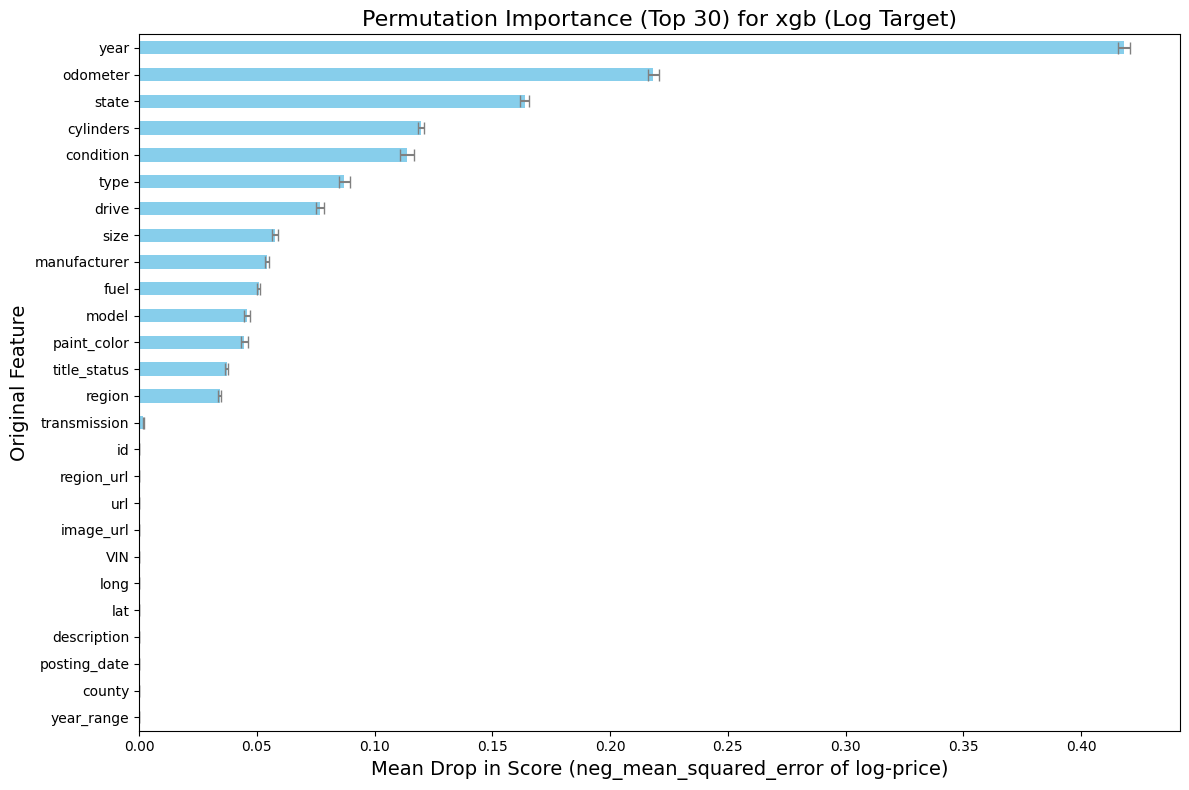

In [28]:
from sklearn.inspection import permutation_importance
model_to_inspect_name_log = 'xgb' # Or 'rf', etc.
if model_to_inspect_name_log in best_models_data_log_target and best_models_data_log_target[model_to_inspect_name_log]:
    model_data_log = best_models_data_log_target[model_to_inspect_name_log]
    if model_data_log and model_data_log['estimator']: # Check if data and estimator exist
        fitted_pipeline_log = model_data_log['estimator']
    else:
        print(f"Estimator not found for {model_to_inspect_name_log}. Skipping permutation importance.")
        fitted_pipeline_log = None # Set to None so the outer if condition handles it
    print(f"\nCalculating permutation importance for: {model_to_inspect_name_log} (trained on log-target)")

    start_time_pi = time.time()

    # Create y_test_log IF it wasn't created before
    if 'y_test_log' not in locals():
        y_test_log = np.log(y_test_original) # Assuming y_test_original is already filtered for price > 0

    scoring_metric_for_importance_log = 'neg_mean_squared_error' # This will be MSE of log(price)

    perm_importance_log = permutation_importance(
        fitted_pipeline_log,
        X_test,  # Original X_test features
        y_test_log, # Target on the log scale
        scoring=scoring_metric_for_importance_log,
        n_repeats=10,
        random_state=42,
        n_jobs=1
    )
    end_time_pi = time.time()
    print(f"Permutation importance calculation time: {end_time_pi - start_time_pi:.2f} seconds")

    original_feature_names_pi = X_test.columns.tolist()
    importance_means_log = pd.Series(perm_importance_log.importances_mean, index=original_feature_names_pi)
    importance_stds_log = pd.Series(perm_importance_log.importances_std, index=original_feature_names_pi)
    sorted_importances_log = importance_means_log.sort_values(ascending=False)

    print(f"\nTop 15 Original Features for {model_to_inspect_name_log} (Permutation Importance on Test Set):")
    print(f"Importance = Mean drop in '{scoring_metric_for_importance_log}' of log(price).")

    num_features_to_print = 30 # You had 30
    for feature_name_idx in sorted_importances_log.head(num_features_to_print).index:
        mean_imp = importance_means_log[feature_name_idx]
        std_imp = importance_stds_log[feature_name_idx]
        print(f"    {str(feature_name_idx):<30} Mean Score Drop: {mean_imp: .4f}  +/- {std_imp: .4f}")

    plt.figure(figsize=(12, 8))
    top_n_features = 30
    plot_importances = sorted_importances_log.head(top_n_features)
    plot_stds = importance_stds_log[plot_importances.index]
    plot_importances.plot(kind='barh', xerr=plot_stds, capsize=4, color='skyblue', ecolor='gray')
    plt.title(f'Permutation Importance (Top {top_n_features}) for {model_to_inspect_name_log} (Log Target)', fontsize=16)
    plt.xlabel(f'Mean Drop in Score ({scoring_metric_for_importance_log} of log-price)', fontsize=14)
    plt.ylabel('Original Feature', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print(f"Skipping permutation importance for {model_to_inspect_name_log} (log-target) as model not found or not trained.")


In [29]:
import scipy.stats as stats
alpha = 0.05
print("\n--- Statistical Comparison: ML Models (trained on log-target) vs. Median Price Baseline ---")
print("--- Errors and Metrics are calculated on the ORIGINAL price scale ---")

# 1. CALCULATE MEDIAN PRICE BASELINE PREDICTIONS AND FULL METRICS (on original scale)
# Ensure y_train_original and y_test_original are defined and valid
if 'y_train_original' not in locals() or not hasattr(y_train_original, 'median'):
    print("Error: y_train_original not defined or invalid. Cannot calculate baseline.")
    # exit or handle error
elif 'y_test_original' not in locals() or not hasattr(y_test_original, 'ravel'):
    print("Error: y_test_original not defined or invalid. Cannot proceed.")
    # exit or handle error
else:
    median_price_train_original = y_train_original.median()
    print(f"Median Price from Original Training Data (Baseline Value): {median_price_train_original:.2f}")

    y_test_original_arr = np.array(y_test_original).ravel()
    baseline_median_predictions_original = np.full_like(y_test_original_arr, fill_value=median_price_train_original, dtype=float)

    baseline_median_abs_errors_original = np.abs(y_test_original_arr - baseline_median_predictions_original)

    mae_median_baseline_original = np.mean(baseline_median_abs_errors_original)
    medae_median_baseline_original = median_absolute_error(y_test_original_arr, baseline_median_predictions_original)
    mse_median_baseline_original = mean_squared_error(y_test_original_arr, baseline_median_predictions_original)
    rmse_median_baseline_original = np.sqrt(mse_median_baseline_original)
    r2_median_baseline_original = r2_score(y_test_original_arr, baseline_median_predictions_original)

    print(f"\n--- Median Price Baseline Performance (Original Scale) ---")
    print(f"  MAE:   {mae_median_baseline_original:.4f}")
    print(f"  MedAE: {medae_median_baseline_original:.4f}")
    print(f"  MSE:   {mse_median_baseline_original:.4f}")
    print(f"  RMSE:  {rmse_median_baseline_original:.4f}")
    print(f"  R²:    {r2_median_baseline_original:.4f}")

    model_abs_errors_original_scale = {}

    if 'best_models_data_log_target' in locals() and best_models_data_log_target and \
       'X_test' in locals() and X_test is not None and not X_test.empty:
        # CORRECTED LOOP:
        for name, model_data in best_models_data_log_target.items(): # model_data is the dictionary
            if model_data is None or model_data.get('estimator') is None: # Check if dict or estimator is None
                print(f"Warning: Model data or estimator for '{name}' is None. Skipping.")
                continue

            fitted_estimator = model_data['estimator'] # Extract the estimator

            try:
                # Use fitted_estimator here
                log_predictions_stat = fitted_estimator.predict(X_test)
                final_predictions_stat = np.exp(log_predictions_stat)

                # Consistent clipping/NaN handling (ensure y_test_original_arr is valid here)
                if np.isnan(final_predictions_stat).any() or np.isinf(final_predictions_stat).any():
                    median_y_test = np.median(y_test_original_arr[~np.isnan(y_test_original_arr)])
                    max_y_test_val = np.max(y_test_original_arr[~np.isinf(y_test_original_arr) & ~np.isnan(y_test_original_arr)])
                    final_predictions_stat = np.nan_to_num(final_predictions_stat, copy=False, nan=median_y_test,
                                                      posinf=max_y_test_val * 5 if max_y_test_val > 0 else 1e12,
                                                      neginf=1.0)

                min_price_observed = y_test_original_arr[~np.isnan(y_test_original_arr)].min() if len(y_test_original_arr[~np.isnan(y_test_original_arr)]) > 0 else 1.0
                max_price_cap_val = (y_test_original_arr[~np.isinf(y_test_original_arr) & ~np.isnan(y_test_original_arr)].max() * 5
                                 if len(y_test_original_arr[~np.isinf(y_test_original_arr) & ~np.isnan(y_test_original_arr)]) > 0 and
                                    y_test_original_arr[~np.isinf(y_test_original_arr) & ~np.isnan(y_test_original_arr)].max() > 0
                                 else 1e12)
                final_predictions_stat = np.clip(final_predictions_stat, min_price_observed, max_price_cap_val)


                if len(y_test_original_arr) == len(final_predictions_stat.ravel()):
                    model_abs_errors_original_scale[name] = np.abs(y_test_original_arr - final_predictions_stat.ravel())
                else:
                    print(f"Shape mismatch for {name} in stat comparison. Expected {len(y_test_original_arr)}, got {len(final_predictions_stat.ravel())}. Skipping.")
            # The AttributeError should no longer be the primary catch if the above is fixed.
            # Keep it for other potential attribute issues with a valid estimator.
            except AttributeError as ae:
                 print(f"Warning: Model '{name}' (estimator type: {type(fitted_estimator)}) encountered AttributeError: {ae}. Skipping.")
            except Exception as e:
                print(f"Could not get predictions for stat comparison for {name}: {e}. Skipping.")

        # 2. PERFORM STATISTICAL COMPARISONS (using absolute errors on original scale)
        if model_abs_errors_original_scale:
            statistical_test_results_log = []
            baseline_model_name_for_reporting = "Median Price Baseline"
            print(f"\n--- Comparing ML models against baseline (based on Absolute Errors) ---")
            print(f"Alpha for significance = {alpha}")

            for ml_model_name, current_ml_model_errors_original in model_abs_errors_original_scale.items():
                current_ml_model_errors_original = np.array(current_ml_model_errors_original)

                if np.isnan(baseline_median_abs_errors_original).any() or np.isnan(current_ml_model_errors_original).any():
                    print(f"Warning: NaNs found in error arrays for comparison with {ml_model_name}. Skipping tests for this model.")
                    statistical_test_results_log.append({
                        'Comparison': f"{baseline_model_name_for_reporting} vs {ml_model_name}",
                        'T-statistic': np.nan, 'T P-value': np.nan,
                        'Wilcoxon-statistic': np.nan, 'Wilcoxon P-value': np.nan,
                        'Note': 'Skipped due to NaNs in errors'
                    })
                    continue

                t_statistic, t_p_value = np.nan, np.nan
                w_statistic, w_p_value = np.nan, np.nan

                try:
                    # Ensure both arrays are clean of NaNs for ttest_rel if not using nan_policy='omit' or ensure policy works.
                    # If using 'omit', ensure there are enough non-NaN pairs.
                    clean_baseline_errors = baseline_median_abs_errors_original[~(np.isnan(baseline_median_abs_errors_original) | np.isnan(current_ml_model_errors_original))]
                    clean_ml_errors = current_ml_model_errors_original[~(np.isnan(baseline_median_abs_errors_original) | np.isnan(current_ml_model_errors_original))]

                    if len(clean_baseline_errors) > 1 and len(clean_ml_errors) > 1 and len(clean_baseline_errors) == len(clean_ml_errors):
                         t_statistic, t_p_value = stats.ttest_rel(clean_baseline_errors, clean_ml_errors) # nan_policy='omit' can also be used if scipy version supports it robustly
                    else:
                        print(f"  T-test: Not enough valid paired data for {ml_model_name} after NaN removal. Skipping.")

                except Exception as e:
                    print(f"  T-test failed for {ml_model_name}: {e}")

                try:
                    # Wilcoxon also needs careful NaN handling. Scipy's wilcoxon with nan_policy='omit' is preferred if available and working.
                    # If not, manual cleaning similar to t-test:
                    clean_baseline_errors_w = baseline_median_abs_errors_original[~(np.isnan(baseline_median_abs_errors_original) | np.isnan(current_ml_model_errors_original))]
                    clean_ml_errors_w = current_ml_model_errors_original[~(np.isnan(baseline_median_abs_errors_original) | np.isnan(current_ml_model_errors_original))]

                    if len(clean_baseline_errors_w) > 1 and len(clean_ml_errors_w) > 1 and len(clean_baseline_errors_w) == len(clean_ml_errors_w):
                        if np.allclose(clean_baseline_errors_w, clean_ml_errors_w):
                            w_p_value = 1.0; w_statistic = 0.0
                        else:
                            diff = clean_baseline_errors_w - clean_ml_errors_w
                            if np.allclose(diff, 0):
                                w_p_value = 1.0; w_statistic = 0.0
                            elif len(np.unique(diff)) < 2 : # Check for distinct differences
                                print(f"  Wilcoxon: Not enough distinct differences for {ml_model_name} after NaN removal. Skipping Wilcoxon.")
                            elif len(diff) < 10: # Check sample size
                                print(f"  Wilcoxon: Too few samples (non-NaN differences: {len(diff)}) for {ml_model_name} for reliable Wilcoxon after NaN removal. Skipping Wilcoxon.")
                            else:
                                w_statistic, w_p_value = stats.wilcoxon(diff, # Use differences for one-sample Wilcoxon
                                                                      zero_method='pratt', alternative='two-sided')
                                # Or, for two-sample: stats.wilcoxon(clean_baseline_errors_w, clean_ml_errors_w, ...)
                    else:
                        print(f"  Wilcoxon: Not enough valid paired data for {ml_model_name} after NaN removal. Skipping.")


                except ValueError as ve:
                    print(f"  Wilcoxon test failed for {ml_model_name}: {ve}.")
                except Exception as e:
                    print(f"  Wilcoxon test failed for {ml_model_name} with an unexpected error: {e}")


                statistical_test_results_log.append({
                    'Comparison': f"{baseline_model_name_for_reporting} vs {ml_model_name}",
                    'T-statistic': t_statistic, 'T P-value': t_p_value,
                    'Wilcoxon-statistic': w_statistic, 'Wilcoxon P-value': w_p_value
                    })

                print(f"\nComparison: {ml_model_name} vs Median Baseline (errors on original price scale)")
                # Recalculate MAE on potentially cleaned errors if NaNs were an issue, or ensure original errors were clean
                mae_ml_model_original = np.nanmean(current_ml_model_errors_original) # Use nanmean if there's a chance of NaNs
                print(f"  MAE for {ml_model_name} (original scale): {mae_ml_model_original:.4f}")

                t_sig_str = "N/A"; w_sig_str = "N/A"
                t_conclusion = ""; w_conclusion = ""

                t_p_value_str = f"{t_p_value:.4f}" if pd.notna(t_p_value) else "N/A"
                w_p_value_str = f"{w_p_value:.4f}" if pd.notna(w_p_value) else "N/A"

                if pd.notna(t_p_value):
                    t_sig = t_p_value < alpha
                    t_sig_str = "Yes" if t_sig else "No"
                    if t_sig:
                        mean_diff = np.nanmean(baseline_median_abs_errors_original) - np.nanmean(current_ml_model_errors_original)
                        if mean_diff > 0: t_conclusion = "ML model significantly better (T-test)."
                        elif mean_diff < 0: t_conclusion = "Median Baseline significantly better (T-test)."
                        else: t_conclusion = "No significant difference in means (T-test), but p-value < alpha (rare)."

                if pd.notna(w_p_value):
                    w_sig = w_p_value < alpha
                    w_sig_str = "Yes" if w_sig else "No"
                    if w_sig:
                        median_of_differences = np.nanmedian(baseline_median_abs_errors_original - current_ml_model_errors_original)
                        if median_of_differences > 0: w_conclusion = "ML model significantly better (Wilcoxon)."
                        elif median_of_differences < 0: w_conclusion = "Median Baseline significantly better (Wilcoxon)."
                        else: w_conclusion = "Median of differences is zero (Wilcoxon), but p-value < alpha."

                print(f"  T-test: p={t_p_value_str}, Significant: {t_sig_str}. {t_conclusion}")
                print(f"  Wilcoxon: p={w_p_value_str}, Significant: {w_sig_str}. {w_conclusion}")

            if statistical_test_results_log:
                stat_tests_log_df = pd.DataFrame(statistical_test_results_log)
                stat_tests_log_df['T-test Significant'] = stat_tests_log_df['T P-value'].apply(
                    lambda p_val: 'Yes' if pd.notna(p_val) and p_val < alpha else ('No' if pd.notna(p_val) else 'Failed/Skipped')
                )
                stat_tests_log_df['Wilcoxon Significant'] = stat_tests_log_df['Wilcoxon P-value'].apply(
                    lambda p_val: 'Yes' if pd.notna(p_val) and p_val < alpha else ('No' if pd.notna(p_val) else 'Failed/Skipped')
                )
                print("\n--- Summary of Statistical Test Results (Log-Target Models, Original Scale Errors) ---")
                for col_name_fmt in ['T P-value', 'Wilcoxon P-value']:
                    if col_name_fmt in stat_tests_log_df:
                        stat_tests_log_df[col_name_fmt] = stat_tests_log_df[col_name_fmt].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
                for col_name_fmt in ['T-statistic', 'Wilcoxon-statistic']:
                     if col_name_fmt in stat_tests_log_df:
                        stat_tests_log_df[col_name_fmt] = stat_tests_log_df[col_name_fmt].apply(lambda x: f"{x:.2f}" if pd.notna(x) else "N/A")
                print(stat_tests_log_df.to_string(index=False))
                try:
                    # Ensure the path is correct for saving
                    csv_filename_log = '/content/drive/My Drive/data-mining/model_results/statistical_test_summary_log_target_models_original_errors.csv'
                    stat_tests_log_df.to_csv(csv_filename_log, index=False)
                    print(f"\nStatistical test summary saved to {csv_filename_log}")
                except Exception as e_save:
                    print(f"\nError saving statistical test summary to CSV: {e_save}")
            else:
                print("\nNo statistical test comparisons were successfully performed for any model.")
        else:
            print("\nNo ML model errors (on original scale) processed for comparison (model_abs_errors_original_scale is empty).")
    else:
        print("\nError: 'best_models_data_log_target' dictionary not found/empty, or 'X_test' not defined/empty. Cannot proceed with statistical comparison.")



--- Statistical Comparison: ML Models (trained on log-target) vs. Median Price Baseline ---
--- Errors and Metrics are calculated on the ORIGINAL price scale ---
Median Price from Original Training Data (Baseline Value): 15590.00

--- Median Price Baseline Performance (Original Scale) ---
  MAE:   11139.1813
  MedAE: 9400.0000
  MSE:   212379709.7639
  RMSE:  14573.2532
  R²:    -0.0507

--- Comparing ML models against baseline (based on Absolute Errors) ---
Alpha for significance = 0.05

Comparison: linear_simple vs Median Baseline (errors on original price scale)
  MAE for linear_simple (original scale): 6621.2399
  T-test: p=0.0000, Significant: Yes. ML model significantly better (T-test).
  Wilcoxon: p=0.0000, Significant: Yes. ML model significantly better (Wilcoxon).

Comparison: linear_poly vs Median Baseline (errors on original price scale)
  MAE for linear_poly (original scale): 6231.4209
  T-test: p=0.0000, Significant: Yes. ML model significantly better (T-test).
  Wilcoxon


--- Visualizing Decision Tree: dt ---


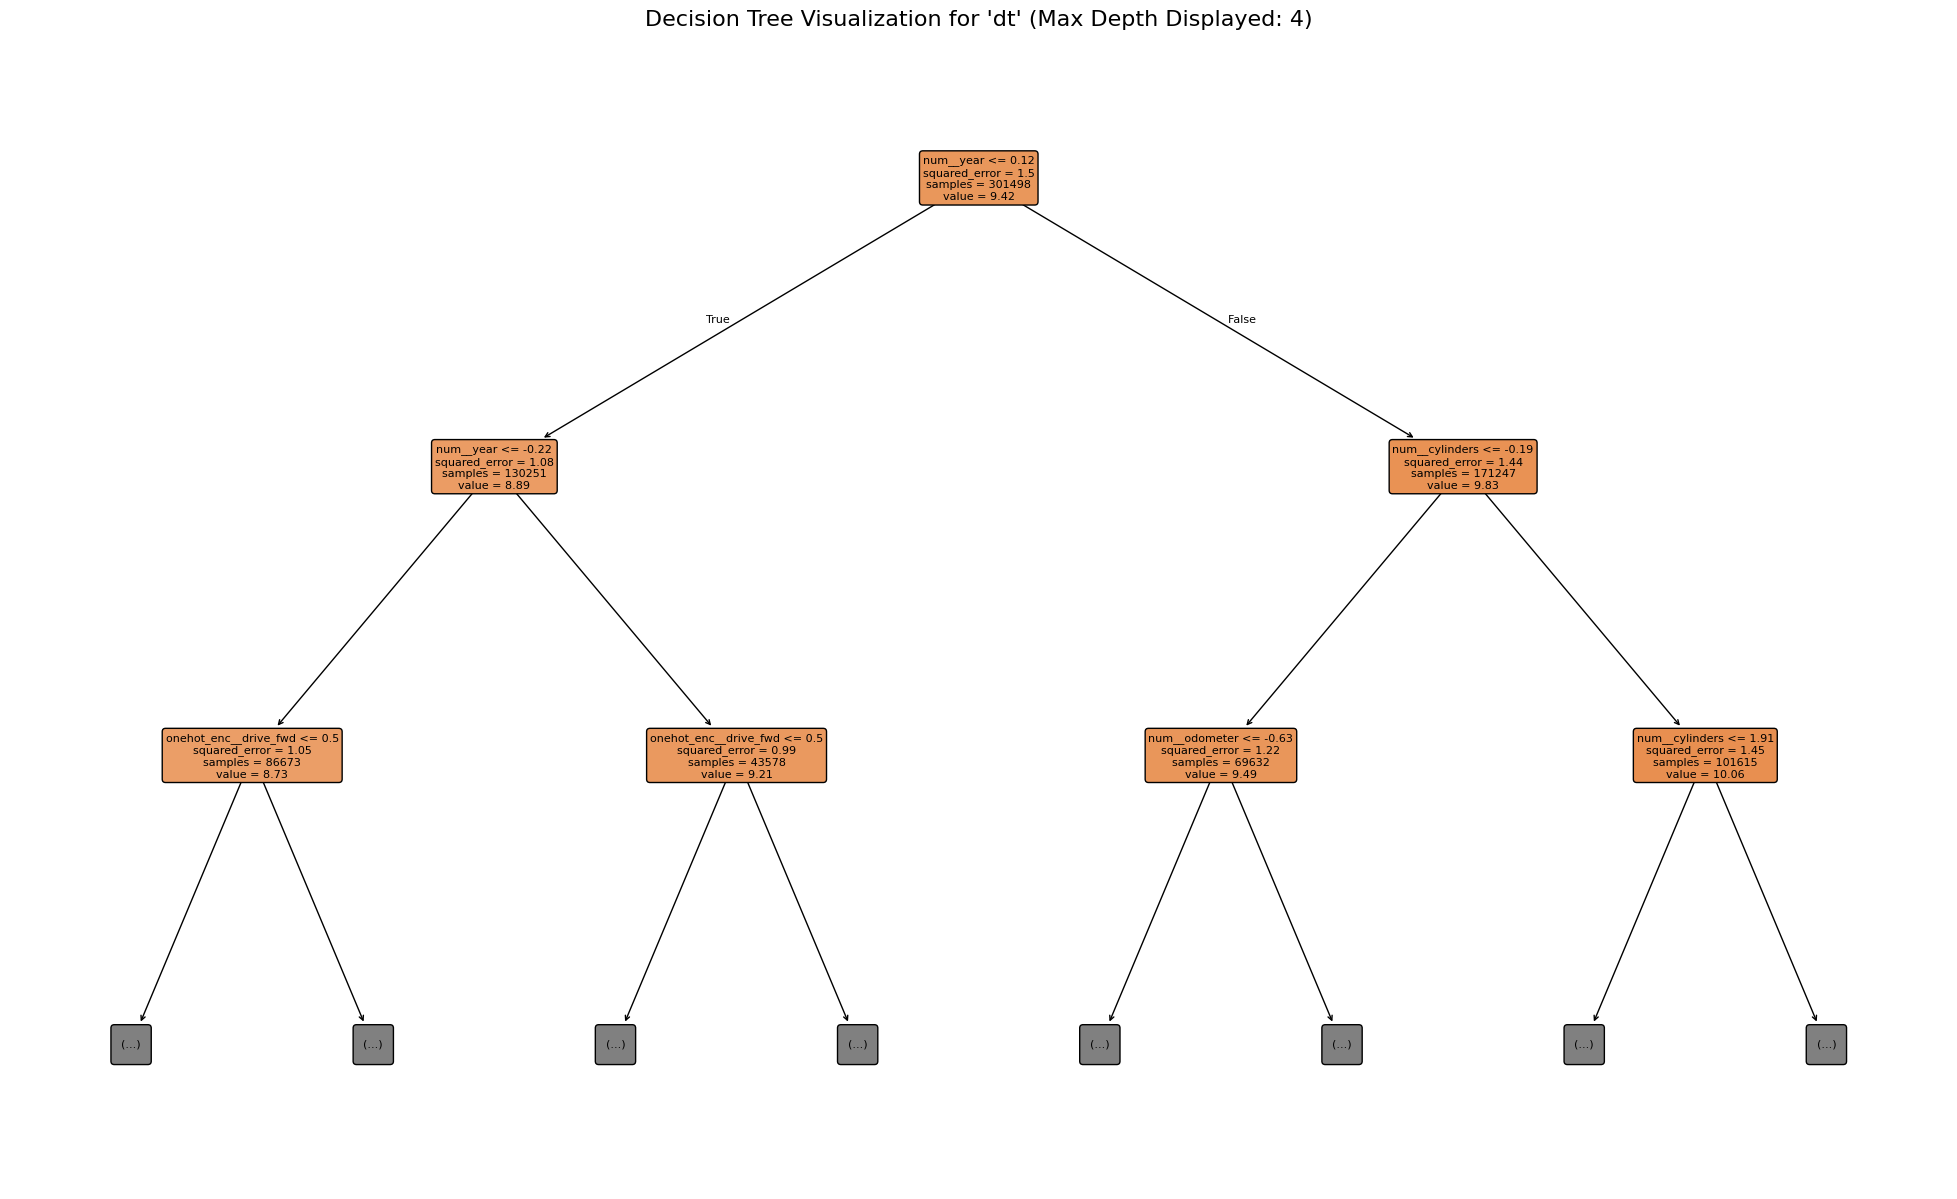


Note on Tree Visualization:
- If the tree is very deep, the full visualization will be huge and unreadable.
- Use the 'max_depth' parameter in plot_tree to show only the top levels.
- Values in nodes for a regressor are typically the mean target value for samples in that node.
- 'mse' is the mean squared error for samples in that node (on the log-transformed target scale).
- 'samples' is the number of training samples reaching that node.
- 'value' is the prediction (mean of target for samples in leaf).


In [30]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


model_name_to_visualize = 'dt' # Make sure this is a Decision Tree model

if model_name_to_visualize in best_models_data_log_target:
    model_data = best_models_data_log_target[model_name_to_visualize]
    if model_data and model_data.get('estimator'):
        fitted_pipeline = model_data['estimator']

        # Extract the DecisionTreeRegressor model and the preprocessor from the pipeline
        try:
            tree_model = fitted_pipeline.named_steps['regressor']
            preprocessor = fitted_pipeline.named_steps['preprocessor']

            if not isinstance(tree_model, DecisionTreeRegressor):
                print(f"Model '{model_name_to_visualize}' is not a DecisionTreeRegressor. Skipping visualization.")
            else:
                print(f"\n--- Visualizing Decision Tree: {model_name_to_visualize} ---")

                # Get feature names AFTER preprocessing
                # This assumes your X_train is available and has the original column names
                # The preprocessor must have been fit during training.
                try:
                    # If preprocessor wasn't fit on X_train directly (e.g. within CV),
                    # you might need to fit it on X_train to get feature names,
                    # or ensure X_train has been transformed by it before.
                    # For simplicity, we assume it's been fit.
                    transformed_feature_names = preprocessor.get_feature_names_out()
                except Exception as e:
                    print(f"Could not get transformed feature names: {e}")
                    print("Plotting without explicit feature names (using indices).")
                    transformed_feature_names = None

                plt.figure(figsize=(25, 15)) # Adjust size as needed, can be very large!
                plot_tree(tree_model,
                          feature_names=transformed_feature_names,
                          filled=True, # Color nodes by majority class (classifier) or value (regressor)
                          rounded=True,
                          precision=2, # For regressor values in nodes
                          fontsize=8,
                          max_depth=2) # IMPORTANT: Limit max_depth for readability! Start small (e.g., 3 or 4).
                                       # Remove or increase max_depth to see more of the tree.
                plt.title(f"Decision Tree Visualization for '{model_name_to_visualize}' (Max Depth Displayed: 4)", fontsize=16)
                plt.show()

                print("\nNote on Tree Visualization:")
                print("- If the tree is very deep, the full visualization will be huge and unreadable.")
                print("- Use the 'max_depth' parameter in plot_tree to show only the top levels.")
                print("- Values in nodes for a regressor are typically the mean target value for samples in that node.")
                print("- 'mse' is the mean squared error for samples in that node (on the log-transformed target scale).")
                print("- 'samples' is the number of training samples reaching that node.")
                print("- 'value' is the prediction (mean of target for samples in leaf).")

        except KeyError:
            print(f"Could not find 'regressor' or 'preprocessor' steps in the pipeline for {model_name_to_visualize}.")
        except Exception as e:
            print(f"An error occurred during visualization setup for {model_name_to_visualize}: {e}")
    else:
        print(f"No valid estimator found for model: {model_name_to_visualize}")
else:
    print(f"Model '{model_name_to_visualize}' not found in best_models_data_log_target.")

In [31]:
import joblib
import os

# Define a path and filename for saving
save_directory = "/content/drive/My Drive/data-mining/" # Adjust to your Drive path
os.makedirs(save_directory, exist_ok=True) # Create directory if it doesn't exist
all_models_data_filename = os.path.join(save_directory, "all_trained_models_and_data_log_target.joblib")

try:
    if 'best_models_data_log_target' in locals() and best_models_data_log_target:
        print(f"Saving all trained models and their data to: {all_models_data_filename}")
        joblib.dump(best_models_data_log_target, all_models_data_filename)
        print("Successfully saved all models and data.")
    else:
        print("Error: 'best_models_data_log_target' not found or is empty. Nothing to save.")

except Exception as e:
    print(f"An error occurred while saving all models and data: {e}")


Saving all trained models and their data to: /content/drive/My Drive/data-mining/all_trained_models_and_data_log_target.joblib
Successfully saved all models and data.


In [41]:
selected_indices = []
loaded_all_models_data = best_models_data_log_target
absurd_cols = [
        'region', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
        'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
        'type', 'paint_color', 'state'
]
# Create a DataFrame for the absurd examples
absurd_data_list = []

# Example 1: Extremely old, high mileage, odd type
absurd_data_list.append({
    'region': 'moonbase alpha', # Unseen region
    'year': 1900,
    'manufacturer': 'gmc', # A common manufacturer
    'model': 'cybertruck', # Mismatched model
    'condition': 'salvage',
    'cylinders': '2 cylinders',
    'fuel': ' antimatter', # Unseen fuel
    'odometer': 5000000.0,
    'title_status': 'missing',
    'transmission': 'automatic',
    'drive': '8wd', # Unseen drive
    'size': 'compact',
    'type': 'hovercraft', # Unseen type
    'paint_color': 'invisible', # Unseen color
    'state': 'ca' # A common state
})

# Example 2: Future car, 1 mile, "new" condition, but odd features
absurd_data_list.append({
    'region': 'new york',
    'year': 2077,
    'manufacturer': 'ford',
    'model': 'pinto', # Old model for future year
    'condition': 'new', # Potentially unseen by OrdinalEncoder
    'cylinders': '16 cylinders', # Extreme
    'fuel': 'gas',
    'odometer': 1.0,
    'title_status': 'clean',
    'transmission': 'manual',
    'drive': 'fwd',
    'size': 'full-size',
    'type': 'truck',
    'paint_color': 'pink',
    'state': 'ny'
})

# Example 3: All numerics are NaN, some categoricals are NaN
# How your preprocessor handles NaNs (SimpleImputer for numerics, encoder settings for categoricals) is key
absurd_data_list.append({
    'region': 'chicago',
    'year': np.nan, # NaN
    'manufacturer': 'toyota',
    'model': np.nan, # NaN, will be handled by CountEncoder
    'condition': np.nan, # NaN, might cause issues with OrdinalEncoder if not handled
    'cylinders': '6 cylinders',
    'fuel': np.nan, # NaN, OneHotEncoder will handle based on training
    'odometer': np.nan, # NaN
    'title_status': 'clean',
    'transmission': 'other',
    'drive': np.nan, # NaN
    'size': np.nan, # NaN
    'type': 'SUV',
    'paint_color': 'custom',
    'state': 'il'
})

# Example 4: Minimal information, mostly common values but one extreme
absurd_data_list.append({
    'region': 'seattle',
    'year': 2010,
    'manufacturer': 'honda',
    'model': 'civic',
    'condition': 'good',
    'cylinders': '4 cylinders',
    'fuel': 'gas',
    'odometer': 10.0, # Extremely low odometer for a 2010 car
    'title_status': 'clean',
    'transmission': 'automatic',
    'drive': 'fwd',
    'size': 'compact',
    'type': 'sedan',
    'paint_color': 'blue',
    'state': 'wa'
})

# Example 5: "Perfect" new car but with an oddity
absurd_data_list.append({
    'region': 'miami',
    'year': pd.Timestamp.now().year, # Current year
    'manufacturer': 'tesla',
    'model': 'model s',
    'condition': 'excellent', # For OrdinalEncoder
    'cylinders': 'other', # Assuming 'other' is a known category
    'fuel': 'electric',
    'odometer': 50.0,
    'title_status': 'clean',
    'transmission': 'automatic',
    'drive': 'awd',
    'size': 'mid-size',
    'type': 'sedan',
    'paint_color': 'red',
    'state': 'fl'
})

X_absurd = pd.DataFrame(absurd_data_list, columns=absurd_cols)
# Fill any columns not specified with a default (e.g., NaN or a common value)
# This is important if absurd_cols contains more cols than your dicts
for col in absurd_cols:
    if col not in X_absurd.columns:
        X_absurd[col] = np.nan # Or a common default like "unknown" for categoricals

print("\n--- Absurd Data Examples (Raw Input) ---")
display(X_absurd)


# Get predictions for these absurd examples
if loaded_all_models_data and not X_absurd.empty:
    model_names_to_test = ['dt', 'xgb', 'rf', 'linear_simple', 'linear_poly'] # Test a few
    absurd_predictions_df = pd.DataFrame(index=X_absurd.index)

    print("\n--- Predictions for Absurd Data Examples ---")

    for model_name in model_names_to_test:
        if model_name in loaded_all_models_data:
            model_data = loaded_all_models_data[model_name]
            if model_data and model_data.get('estimator'):
                pipeline = model_data['estimator']
                print(f"\nPredicting with {model_name}...")
                try:
                    log_preds_absurd = pipeline.predict(X_absurd)
                    original_scale_preds_absurd = np.exp(log_preds_absurd)
                    absurd_predictions_df[f'{model_name}_Predicted_Price'] = original_scale_preds_absurd
                except Exception as e:
                    print(f"  ERROR predicting with {model_name}: {e}")
                    absurd_predictions_df[f'{model_name}_Predicted_Price'] = f"Error: {e}" # Store error message
            else:
                print(f"  Estimator not found for {model_name}.")
                absurd_predictions_df[f'{model_name}_Predicted_Price'] = "Estimator Missing"
        else:
            print(f"Model {model_name} not found in loaded data.")
            absurd_predictions_df[f'{model_name}_Predicted_Price'] = "Model Not Found"

    print("\n--- Predictions on Absurd Data (Original Price Scale) ---")
    # It's tricky to style if some columns have error strings, so print simply
    for idx, row in absurd_predictions_df.iterrows():
        print(f"\nAbsurd Example {idx+1}:")
        # Display corresponding raw input for context
        # print("Raw Input:")
        # print(X_absurd.loc[idx].to_dict())
        print("Predictions:")
        for model_col, pred_val in row.items():
            if isinstance(pred_val, (int, float, np.number)):
                 print(f"  {model_col}: {pred_val:,.2f}")
            else:
                 print(f"  {model_col}: {pred_val}")
        print("-" * 30)

else:
    print("Models not loaded or absurd data is empty. Skipping predictions.")


--- Absurd Data Examples (Raw Input) ---


,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,new york,1900.0,gmc,cybertruck,salvage,2 cylinders,antimatter,5000000.0,missing,automatic,8wd,compact,hovercraft,invisible,ca
1,new york,2077.0,ford,pinto,new,16 cylinders,gas,1.0,clean,manual,fwd,full-size,truck,pink,ny
2,chicago,NaN,toyota,NaN,NaN,6 cylinders,NaN,NaN,clean,other,NaN,NaN,SUV,custom,il
3,seattle,2010.0,honda,civic,good,4 cylinders,gas,10.0,clean,automatic,fwd,compact,sedan,blue,wa
4,miami,2025.0,tesla,model s,excellent,other,electric,50.0,clean,automatic,awd,mid-size,sedan,red,fl



--- Predictions for Absurd Data Examples ---

Predicting with dt...
  ERROR predicting with dt: Found unknown categories [nan] in column 0 during transform

Predicting with xgb...
  ERROR predicting with xgb: Found unknown categories [nan] in column 0 during transform

Predicting with rf...
  ERROR predicting with rf: Found unknown categories [nan] in column 0 during transform

Predicting with linear_simple...
  ERROR predicting with linear_simple: Found unknown categories [nan] in column 0 during transform

Predicting with linear_poly...
  ERROR predicting with linear_poly: Found unknown categories [nan] in column 0 during transform

--- Predictions on Absurd Data (Original Price Scale) ---

Absurd Example 1:
Predictions:
  dt_Predicted_Price: Error: Found unknown categories [nan] in column 0 during transform
  xgb_Predicted_Price: Error: Found unknown categories [nan] in column 0 during transform
  rf_Predicted_Price: Error: Found unknown categories [nan] in column 0 during transfor